## Лабораторная работа № 1 
## Выполнение разведочного анализа больших данных с использованием фреймворка Apache Spark

### Часть 2

В данной части работы рассмотрены:
* разведочный анализ данных;
* работа с Dataframe API фреймворка `Apache Spark`.

Подключаем необходимые библиотеки.

In [109]:
import os
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.sql.functions import (
    col, lit, sum, mean, when,
    explode, count, desc, floor,
    corr, array_contains, lit, first
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Сформируем объект конфигурации для `Apache Spark`, указав необходимые параметры.

In [110]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    user_name = os.getenv("USER")
    
    conf = SparkConf()
    conf.setAppName("lab 1 Test")
    conf.setMaster("yarn")
    conf.set("spark.submit.deployMode", "client")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "2")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "2")
    conf.set("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    conf.set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///user/{user_name}/warehouse")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

Создаём сам объект конфигурации.

In [111]:
conf = create_spark_configuration()

Создаём и выводим на экран сессию `Apache Spark`. В процессе создания сессии происходит подключение к кластеру `Apache Hadoop`, что может занять некоторое время.

In [112]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

24/12/14 18:40:54 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Укажем базу данных, которая была создана в первой части лабораторной работы.

In [5]:
database_name = "kachurin_database"

Установим созданную базу данных как текущую.

In [6]:
spark.catalog.setCurrentDatabase(database_name)

Прочитаем сохранённую в предыдущей части работы таблицу и загрузим её в `Spark Dataframe`.

In [7]:
df = spark.table("sobd_lab1_table_1")

Выведем прочитанную таблицу на экран.

In [8]:
df.show()

+--------------------+----------+---------------+------------------+--------------+------------+---------+--------+---------+--------------+-------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|
+--------------------+----------+---------------+------------------+--------------+------------+---------+--------+---------+--------------+-------------------+
|299f9d6c22aa24bc9...|2022-05-16|            PHL|               MIA|         false|       false|    false|  161.86|    197.6|             1|             1077.0|
|5371f89133a4357ea...|2022-05-16|            PHL|               MIA|         false|       false|    false|  161.86|    197.6|             7|             1540.0|
|5d418050b24b313c9...|2022-05-16|            PHL|               MIA|         false|       false|    false|  161.86|    197.6|             7|             1540.0|
|2fe937c3219d7e48c...|2022-05-16| 

Посмотрим на схему данных.

In [9]:
df.printSchema()

root
 |-- legId: string (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: float (nullable = true)
 |-- totalFare: float (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: float (nullable = true)



Вычислим количество строк в датафрейме.

In [10]:
df.count()

82138753

#### Анализ столбца `legId`

Отсортируем датафрейм по столбцу `legId`, который может рассматриваться в качестве первичного ключа таблицы.

In [11]:
df.orderBy("legId", ascending=False).show()

+--------------------+----------+---------------+------------------+--------------+------------+---------+--------+---------+--------------+-------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|
+--------------------+----------+---------------+------------------+--------------+------------+---------+--------+---------+--------------+-------------------+
|ffffffc70e6f33139...|2022-09-21|            SFO|               EWR|         false|       false|    false|  347.91|    397.6|             9|             2568.0|
|ffffffc70e6f33139...|2022-09-21|            SFO|               EWR|         false|       false|    false|  325.58|    373.6|             9|             2568.0|
|ffffffc70e6f33139...|2022-09-21|            SFO|               EWR|          true|       false|    false|  273.49|    317.6|             9|             2568.0|
|ffffffc70e6f33139...|2022-09-21| 

Видно, что некоторые значения ключа довольно странные (представляют собой больше описание, чем ключ). Удалим из датафрейма строки с такими ключами, оставив только подходящие по шаблону.

In [12]:
# Регулярное выражение для legId длиной 32 символа, состоящих из цифр и букв (a-f, A-F)
legid_pattern = r"^[a-fA-F0-9]{32}$"
# Фильтрация DataFrame
df = df.filter(col("legId").rlike(legid_pattern))
df.show()

+--------------------+----------+---------------+------------------+--------------+------------+---------+--------+---------+--------------+-------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|
+--------------------+----------+---------------+------------------+--------------+------------+---------+--------+---------+--------------+-------------------+
|299f9d6c22aa24bc9...|2022-05-16|            PHL|               MIA|         false|       false|    false|  161.86|    197.6|             1|             1077.0|
|5371f89133a4357ea...|2022-05-16|            PHL|               MIA|         false|       false|    false|  161.86|    197.6|             7|             1540.0|
|5d418050b24b313c9...|2022-05-16|            PHL|               MIA|         false|       false|    false|  161.86|    197.6|             7|             1540.0|
|2fe937c3219d7e48c...|2022-05-16| 

In [13]:
df.count()

82138753

Проверим наличие дубликатов в датафрейме.

In [14]:
(
    df
    .groupBy("legId")
    .count()
    .where("count > 1")
    .orderBy("count", ascending=False)
    .show()
)

+--------------------+-----+
|               legId|count|
+--------------------+-----+
|f6a29d9fb31867ca4...|   61|
|6365830250822d873...|   61|
|65f59b3c81d5fcdea...|   61|
|b2feca28d8d28bff3...|   61|
|acba22c02469274e4...|   61|
|809668b03345672b1...|   61|
|318ae5fe46ac6a4ed...|   61|
|fea1345623050a76e...|   61|
|772e69e86a07ea59a...|   60|
|cede8a1691d5e1ec5...|   60|
|a9bfd250126de5359...|   60|
|c72ce952d39df91e1...|   60|
|b23c4d7a6643c64a9...|   60|
|bbf11af6124b559fe...|   60|
|5a39e73da820a6fa6...|   60|
|c215f258ded6b7276...|   60|
|ee1de6530a1df26dc...|   60|
|235e702c4b4d681e7...|   60|
|fa8dbc842a6dbf1f2...|   60|
|17861665c80288f01...|   60|
+--------------------+-----+
only showing top 20 rows



In [15]:
duplicate_counts_specific = (
    df
    .groupBy("legId")
    .count()
    .filter("count > 1")  # Оставляем только дубликаты
    .orderBy("count", ascending=False)
)

# Показываем дубликаты
duplicate_counts_specific.show()


+--------------------+-----+
|               legId|count|
+--------------------+-----+
|f6a29d9fb31867ca4...|   61|
|6365830250822d873...|   61|
|b2feca28d8d28bff3...|   61|
|65f59b3c81d5fcdea...|   61|
|acba22c02469274e4...|   61|
|318ae5fe46ac6a4ed...|   61|
|809668b03345672b1...|   61|
|fea1345623050a76e...|   61|
|772e69e86a07ea59a...|   60|
|d811b32e23386210f...|   60|
|a9bfd250126de5359...|   60|
|c72ce952d39df91e1...|   60|
|b23c4d7a6643c64a9...|   60|
|f8bf82c679ca0f324...|   60|
|5a39e73da820a6fa6...|   60|
|cede8a1691d5e1ec5...|   60|
|ee1de6530a1df26dc...|   60|
|cfee135824bd94d13...|   60|
|fa8dbc842a6dbf1f2...|   60|
|17861665c80288f01...|   60|
+--------------------+-----+
only showing top 20 rows



In [16]:
from pyspark.sql import functions as F

from pyspark.sql.functions import col

duplicate_rows = (
    df.groupBy("legId")
    .count()
    .filter("count > 1")
    .select("legId")
)

# Получаем строки с дубликатами
duplicate_data = df.join(duplicate_rows, on="legId", how="inner")

# Проверяем уникальные строки для каждой группы legId
duplicate_data.groupBy("legId").agg(F.countDistinct(*df.columns).alias("unique_row_count")).show()


+--------------------+----------------+
|               legId|unique_row_count|
+--------------------+----------------+
|0000c808a6ac95ca4...|               2|
|000859f937218c874...|              11|
|000879d48044878f4...|               4|
|000be6b99cca4e22d...|               6|
|000d4e0e93e504ffd...|               6|
|000e683f0ba4e677a...|               6|
|001421c4eca26df2f...|               2|
|0018c0838610a02c7...|               4|
|0018c35572fd06c1a...|              17|
|001ab52bfcde025b5...|               3|
|00207ff4ad0c2a56f...|               7|
|0021caa113122bb1d...|               4|
|0022cf97249f0dbe6...|               3|
|00283872e1ae068a9...|               8|
|00287c494a190c2bb...|               1|
|0029dd35b1b6e7534...|              12|
|002a39cfb351aa250...|               3|
|002cdc556b83dd74a...|               1|
|002db218a7af20dcd...|               8|
|003183f07f261d2f7...|               6|
+--------------------+----------------+
only showing top 20 rows



Дубликаты есть. Посмотрим, что они собой представляют (на примере одной записи).

In [17]:
df.filter(col("legId") == "318ae5fe46ac6a4ed5e1ee55f5b53677").show()

+--------------------+----------+---------------+------------------+--------------+------------+---------+--------+---------+--------------+-------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|
+--------------------+----------+---------------+------------------+--------------+------------+---------+--------+---------+--------------+-------------------+
|318ae5fe46ac6a4ed...|2022-09-07|            LAX|               ORD|         false|       false|    false|    38.0|   145.58|             0|               NULL|
|318ae5fe46ac6a4ed...|2022-09-07|            LAX|               ORD|         false|       false|    false|    38.0|   145.58|             0|               NULL|
|318ae5fe46ac6a4ed...|2022-09-07|            LAX|               ORD|         false|       false|    false|    38.0|   145.58|             0|               NULL|
|318ae5fe46ac6a4ed...|2022-09-07| 

In [18]:
from functools import reduce
from pyspark.sql import functions as F

# Фильтруем строки с заданным legId
filtered_rows = df.filter(F.col("legId") == "318ae5fe46ac6a4ed5e1ee55f5b53677")

# Получаем эталонную строку (первую)
reference_row = filtered_rows.first()
reference_dict = reference_row.asDict()

# Создаем условия для строк, которые отличаются хотя бы по одному столбцу
conditions = [
    F.col(column) != reference_dict[column] for column in df.columns if column != "legId"
]

# Объединяем условия с помощью reduce
different_rows_condition = reduce(lambda x, y: x | y, conditions)

# Фильтруем строки, которые отличаются
different_rows = filtered_rows.filter(different_rows_condition)

# Показываем только строки, которые отличаются
different_rows.show()


+--------------------+----------+---------------+------------------+--------------+------------+---------+--------+---------+--------------+-------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|
+--------------------+----------+---------------+------------------+--------------+------------+---------+--------+---------+--------------+-------------------+
|318ae5fe46ac6a4ed...|2022-09-07|            LAX|               ORD|         false|       false|    false|    19.0|   126.58|             0|               NULL|
|318ae5fe46ac6a4ed...|2022-09-07|            LAX|               ORD|         false|       false|    false|    19.0|   126.58|             0|               NULL|
|318ae5fe46ac6a4ed...|2022-09-07|            LAX|               ORD|         false|       false|    false|    38.0|   107.58|             0|               NULL|
|318ae5fe46ac6a4ed...|2022-09-07| 

Похоже на полную идентичность строк. Удалим дубликаты.

Удаление дубликатов `legId` по столбцам с проверкой всех столбцов

In [19]:
df = df.dropDuplicates(["legId", "startingAirport", "destinationAirport", "baseFare", "totalFare","flightDate", "isBasicEconomy","isRefundable","isNonStop","seatsRemaining","totalTravelDistance"])
df.count()

37306550

In [20]:
df.show()

+--------------------+----------+---------------+------------------+--------------+------------+---------+--------+---------+--------------+-------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|
+--------------------+----------+---------------+------------------+--------------+------------+---------+--------+---------+--------------+-------------------+
|915602a32f03ef585...|2022-05-23|            DTW|               LAX|         false|       false|    false|   480.0|    539.6|             7|             1985.0|
|925bc77c68beb3921...|2022-05-23|            DTW|               MIA|          true|       false|    false|  104.19|    141.2|             9|             1589.0|
|66bde28b940fda88d...|2022-05-23|            EWR|               DFW|         false|       false|     true|  245.58|    278.6|             3|             1380.0|
|2fce5428b0a9ab292...|2022-05-23| 

#### Анализ столбца `startingAirport`

Посмотрим внимательно на значения в столбце. Видно, что в данном столбце расположен **категориальный признак**.

Введем функцию, определяющую количество NULL-значений в столбце.

In [21]:
# Функция для подсчета количества NULL и not NULL значений в столбце
def count_nulls(data: DataFrame, column_name: str) -> None:
    """
    Подсчет количества null и not null значений в указанном столбце.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для подсчета null и not null значений.
    
    Returns:
        None
    """
    # Подсчет количества null значений в указанном столбце
    null_counts = data.select(
        sum(col(column_name).isNull().cast("int"))
    ).collect()[0][0]

    # Подсчет количества not null значений в указанном столбце
    not_null_counts = data.select(
        sum(col(column_name).isNotNull().cast("int"))
    ).collect()[0][0]

    # Вывод результатов
    print(f"Число колонок с NULL: {null_counts} "
          f"({100 * null_counts / (null_counts + not_null_counts):.2f}%)")

In [22]:
count_nulls(data=df, column_name="startingAirport")

Число колонок с NULL: 0 (0.00%)


Видно, что столбец `startingAirport` не содержит пропущенных значений.

Создадим функцию расчета и визуализации распределения категориальных признаков.

In [23]:
# Функция для визуализации распределения категориальных признаков
def plot_cat_distribution(data: DataFrame, column_name: str, top_n: int = 20) -> None:
    """
    Построение распределения категориального признака.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для группировки.
        top_n (int): Количество топ-значений для отображения.
    
    Returns:
        None
    """
    # Группировка данных по столбцу и подсчет количества
    categories = (
        data
        .groupBy(column_name)
        .count()
        .orderBy("count", ascending=False)
    )
    
    print(f"Количество категорий признака {column_name}: {categories.count()}")

    categories = (
        categories
        .limit(top_n)
        .toPandas()
    )
    
    # Визуализация с использованием Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column_name, y="count", data=categories)
    plt.title(f"Barplot of \"{column_name}\" counts")
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

Количество категорий признака startingAirport: 16


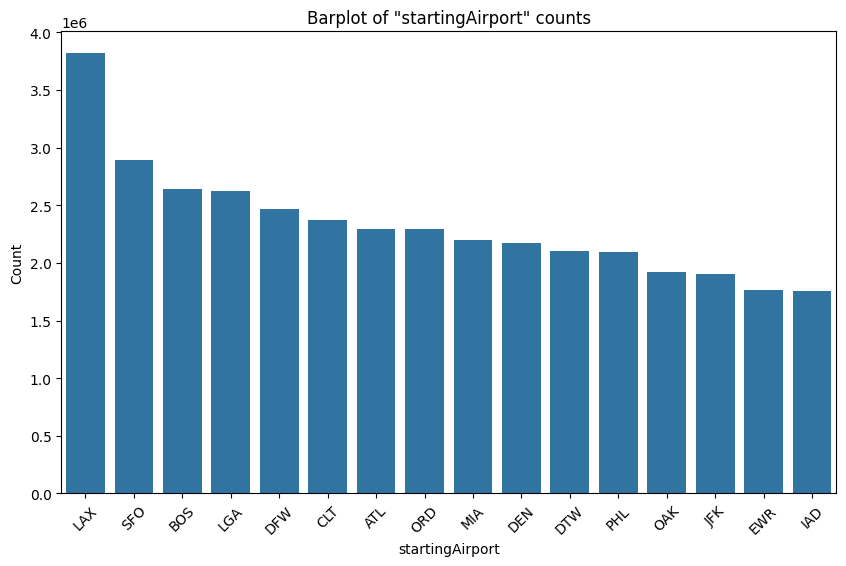

In [24]:
plot_cat_distribution(data=df, column_name="startingAirport")

Видно, что в представленном датасете задействовано 16 аэропортов отправления, при этом распределение рейсов между ними неравномерно.  


#### Анализ столбца `destinationAirport`

В соответствии с описанием и содержанием датасета логично считать данный признак **категориальным**. Проверим его на наличие пропущенных значений.

In [25]:
count_nulls(data=df, column_name="destinationAirport")

Число колонок с NULL: 0 (0.00%)


Видно, что столбец `destinationAirport` не содержит пропущенных значений.

Количество категорий признака destinationAirport: 16


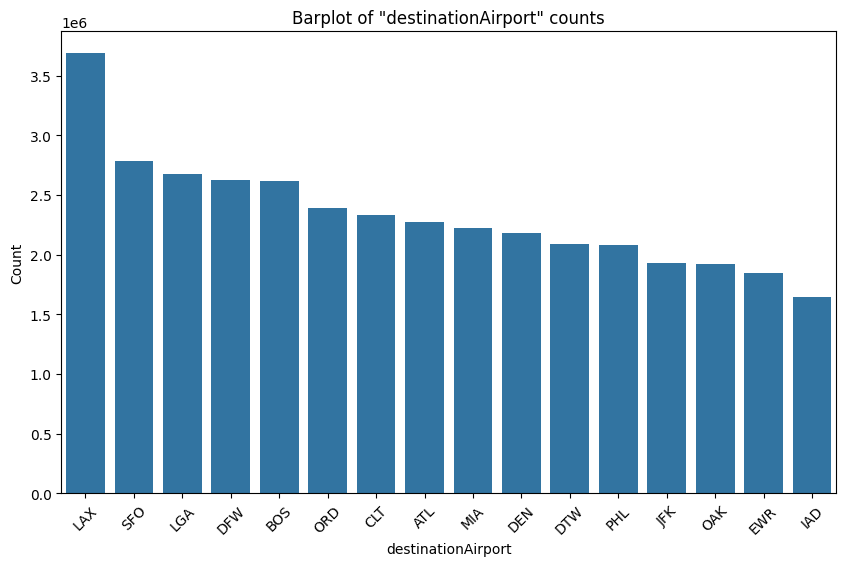

In [26]:
plot_cat_distribution(data=df, column_name="destinationAirport")

#### Анализ столбца `totalFare`

В соответствии с описанием и содержанием датасета логично считать данный признак **количественным**. Проверим его на наличие пропущенных значений.

In [27]:
count_nulls(data=df, column_name="totalFare")

Число колонок с NULL: 0 (0.00%)


Видно, что пропуски в данном столбце отсутствуют.

Создадим функцию, позволяющую рассчитывать статистические показатели данных в столбцах и строить диаграмму "ящик с усами" для оценки наличия выбросов.

In [28]:
def plot_boxplots(data: DataFrame,
                  columns: list[str],
                  sample_fraction: float = 0.1) -> None:
    """
    Построение boxplot для нескольких столбцов в PySpark DataFrame.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        columns (list of str): Список имен столбцов для построения boxplot.
        sample_fraction (float): Доля данных для семплирования выбросов.
    
    Returns:
        None
    """
    box_data = []

    for column in columns:
        # Вычисление квантилей
        quantiles = data.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
        q1, median, q3 = quantiles

        # Вычисление IQR и границ усов
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Фильтрация выбросов
        filtered_df = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
        outliers_df = data.filter((col(column) < lower_bound) | (col(column) > upper_bound))

        # Вычисление минимального и максимального значений
        min_value = data.agg({column: "min"}).collect()[0][0]
        mean_value = data.agg({column: "mean"}).collect()[0][0]
        std_value = data.agg({column: "std"}).collect()[0][0]
        max_value = data.agg({column: "max"}).collect()[0][0]

        # Ограничение усов минимальным и максимальным значениями
        lower_bound = max(lower_bound, min_value)
        upper_bound = min(upper_bound, max_value)

        # Семплирование выбросов
        outliers = []
        if not outliers_df.isEmpty():
            sampled_outliers_df = outliers_df.sample(sample_fraction)
            outliers = (
                sampled_outliers_df
                .select(column)
                .limit(1000)
                .collect()
            )
            outliers = [row[column] for row in outliers]
            
            # Добавление минимального и максимального значений, если они 
            # относятся к выбросам и не присутствуют в семпле
            if min_value < lower_bound and min_value not in outliers:
                outliers.append(min_value)
            if max_value > upper_bound and max_value not in outliers:
                outliers.append(max_value)

        # Подготовка данных для axes.bxp
        box_data.append({
            'whislo': lower_bound,  # Нижняя граница усов
            'q1': q1,               # Первый квартиль
            'med': median,          # Медиана
            'q3': q3,               # Третий квартиль
            'whishi': upper_bound,  # Верхняя граница усов
            'fliers': outliers      # Выбросы
        })
        
    # Вывод статистических характеристик
    print(f"Минимальное значение:          {min_value:.2f}")
    print(f"Среднее значение:              {mean_value:.2f}")
    print(f"Среднеквадратичное отклонение: {std_value:.2f}")
    print(f"Первый квартиль:               {q1:.2f}")
    print(f"Медиана:                       {median:.2f}")
    print(f"Третий квартиль:               {q3:.2f}")
    print(f"Максимальное значение:         {max_value:.2f}")

    # Построение boxplot
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.bxp(box_data, 
           vert=False, 
           positions=range(1, len(columns) + 1), widths=0.5)
    ax.set_yticks(range(1, len(columns) + 1))
    ax.set_yticklabels(columns)
    ax.set_xlabel('Value')
    ax.set_title('Boxplots')
    ax.grid(True)
    plt.show()

Минимальное значение:          19.59
Среднее значение:              375.85
Среднеквадратичное отклонение: 197.73
Первый квартиль:               232.60
Медиана:                       347.11
Третий квартиль:               481.60
Максимальное значение:         8260.61


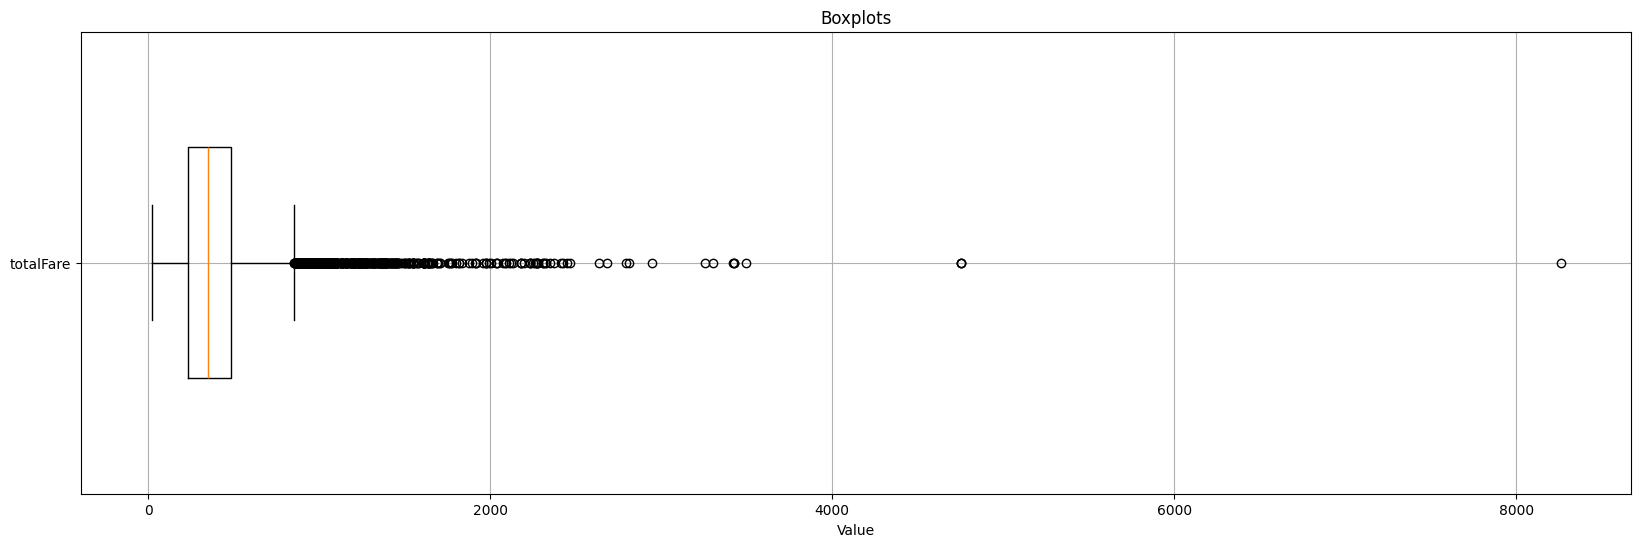

In [29]:
plot_boxplots(data=df, columns=["totalFare"])

Наблюдаем значительное количество выбросов в данных. Для более тщательного исследования создадим функцию для визуализации распределения категориального признака.

In [30]:
def plot_quant_distribution(data: DataFrame,
                            column: str,
                            num_bins: int = 200) -> None:
    """
    Построение гистограммы для количественной переменной с 
    использованием PySpark и Seaborn.

    Args:
        data (DataFrame): DataFrame с данными.
        column_name (str): Название колонки с количественной переменной.
        num_bins (int): Количество бинов для гистограммы.

    Returns:
        None
    """
    # Находим минимальное и максимальное значения колонки
    min_value = data.agg({column: "min"}).collect()[0][0]
    max_value = data.agg({column: "max"}).collect()[0][0]

    # Размер бина
    bin_size = (max_value - min_value) / num_bins

    # Добавляем колонку с номером бина
    data = data.withColumn(
        "bin", 
        floor((col(column) - min_value) / bin_size)
    )

    # Группируем по номеру бина и считаем количество строк в каждом бине
    bin_counts = data.groupBy("bin").count()

    # Преобразуем результат в Pandas DataFrame для построения гистограммы
    bin_counts_pd = bin_counts.limit(1000).toPandas()
    
    # Создаем массив границ бинов
    bin_edges = [min_value + i * bin_size for i in range(num_bins + 2)]
    
    # Преобразуем номера бинов в центры бинов
    bin_centers = [
        (bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins + 1)
    ]
    
    # Добавляем центры бинов в Pandas DataFrame
    bin_counts_pd['bin_center'] = bin_counts_pd['bin'].apply(
        lambda x: bin_centers[int(x)]
    )
    
    # Построение гистограммы с использованием Seaborn
    plt.figure(figsize=(20, 6))
    sns.histplot(data=bin_counts_pd, x="bin_center", 
                 weights="count", kde=True, bins=num_bins + 1)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.title(f"Распределение количественного признака \"{column}\"")
    plt.grid(True)
    plt.show()

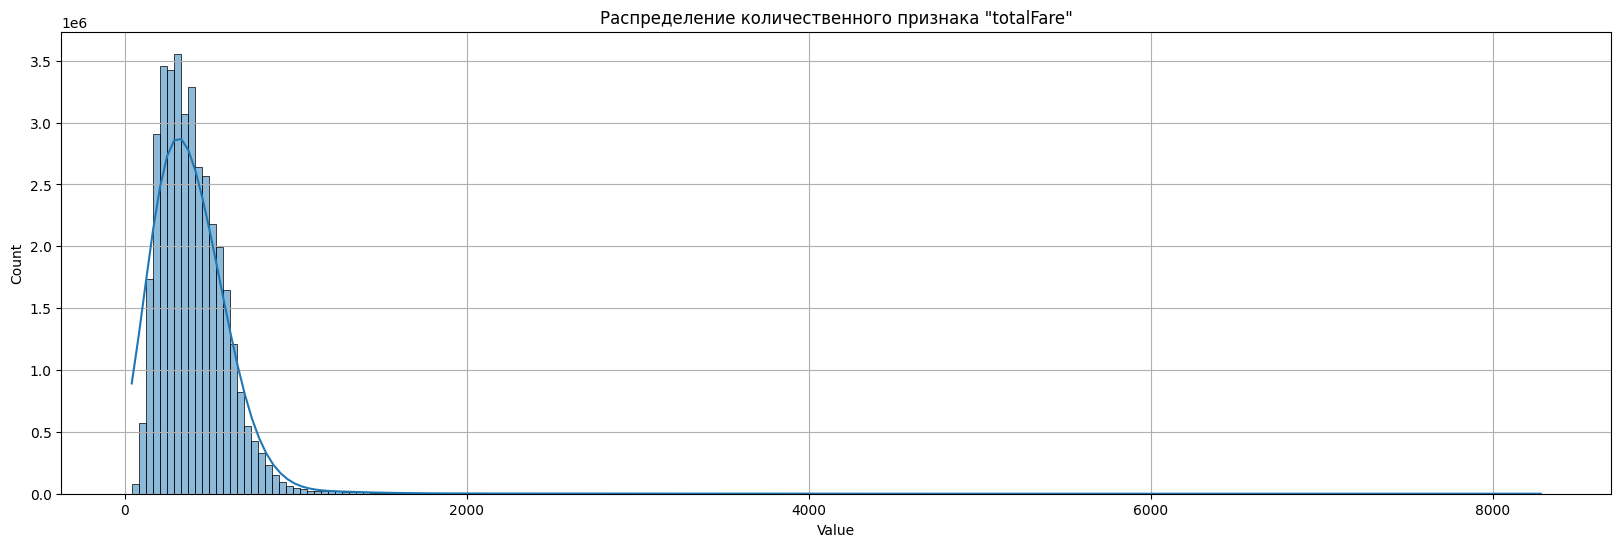

In [31]:
plot_quant_distribution(data=df, column="totalFare")

Видно, что почти все данные не превышают значения 2000, но при этом наблюдается малое количество довольно сильных выбросов. Обрежем эти выбросы, установив для них максимальную границу.

In [32]:
df = df.withColumn(
    "totalFare",
    when(col("totalFare") > 2000.0, 2000.0)
        .otherwise(col("totalFare"))
)

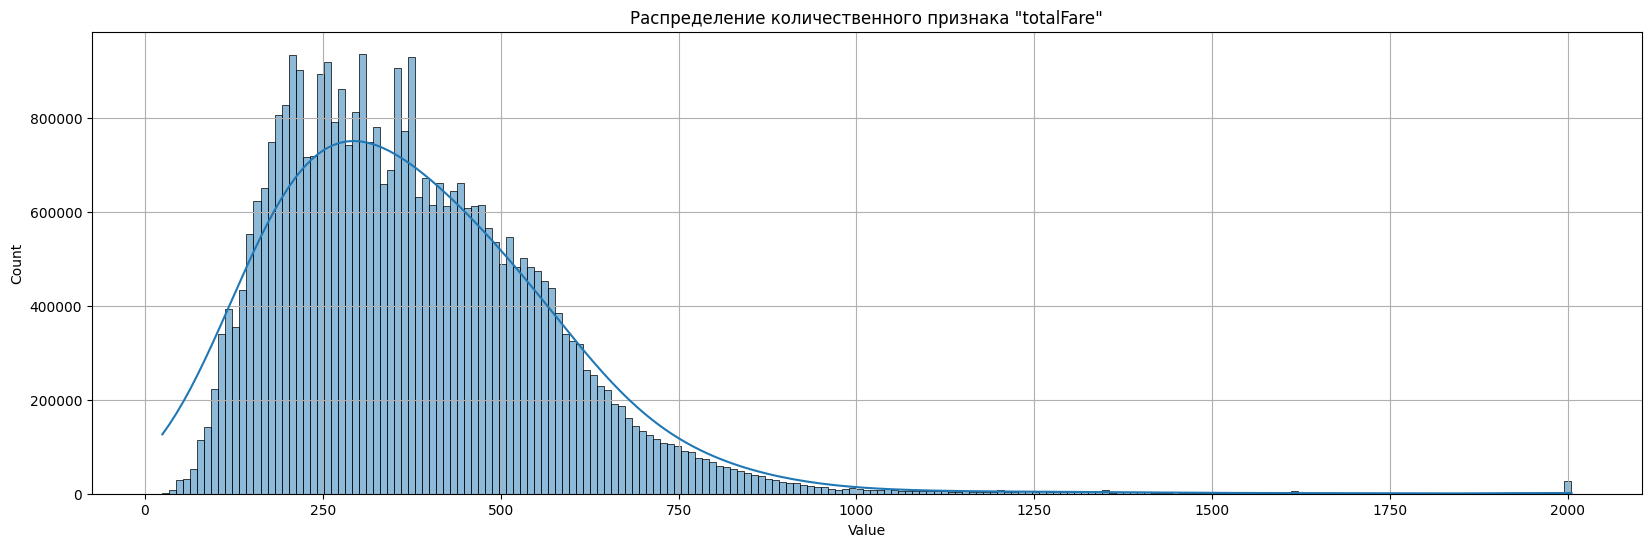

In [33]:
plot_quant_distribution(data=df, column="totalFare")

Минимальное значение:          19.59
Среднее значение:              375.51
Среднеквадратичное отклонение: 194.12
Первый квартиль:               233.20
Медиана:                       347.20
Третий квартиль:               482.21
Максимальное значение:         2000.00


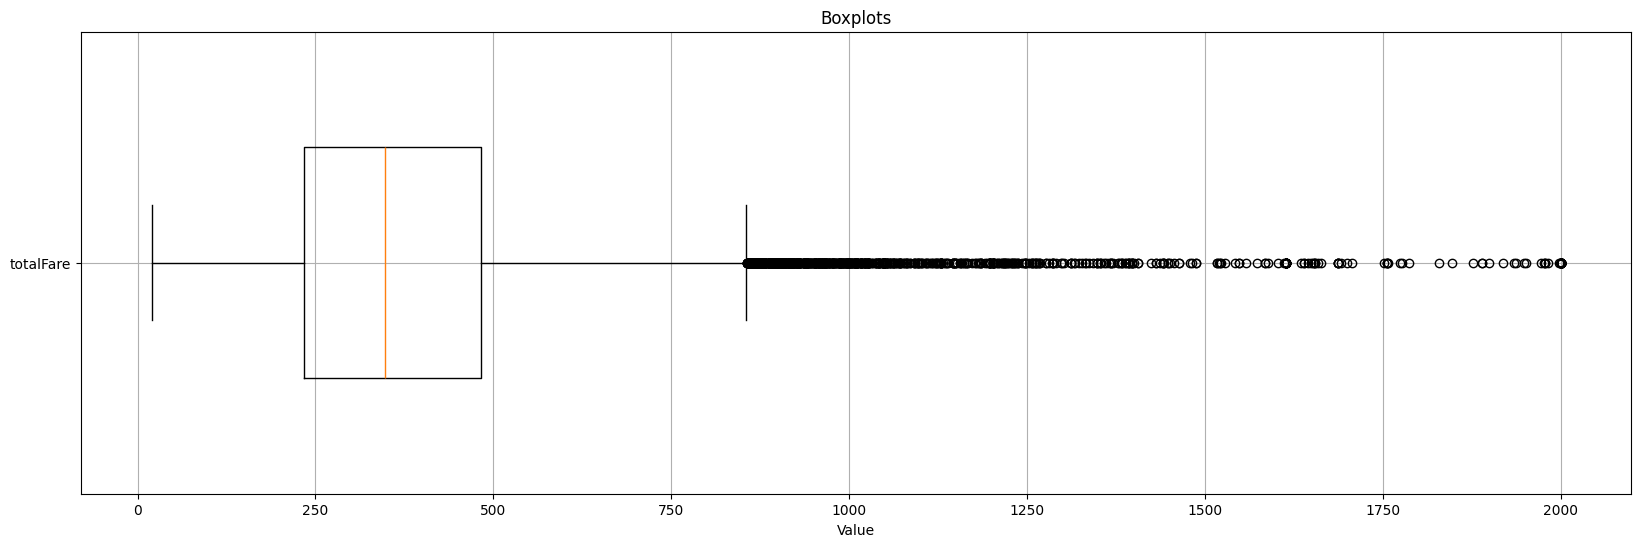

In [34]:
plot_boxplots(data=df, columns=["totalFare"])

In [114]:
def remove_outliers_and_count(data: DataFrame, columns: list[str]) -> DataFrame:
    """
    Удаление выбросов из PySpark DataFrame и подсчёт их количества.

    Args:
        data (DataFrame): Исходный DataFrame.
        columns (list of str): Список имен столбцов, для которых нужно удалить выбросы.
    
    Returns:
        DataFrame: DataFrame без выбросов.
    """
    total_outliers_count = 0  # Общий счётчик выбросов
    
    for column in columns:
        # Вычисление квантилей
        quantiles = data.approxQuantile(column, [0.25, 0.75], 0.01)
        q1, q3 = quantiles

        # Вычисление IQR и границ
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Подсчёт выбросов
        outliers_count = data.filter((col(column) < lower_bound) | (col(column) > upper_bound)).count()
        print(f"Столбец: {column} | Число выбросов: {outliers_count}")

        # Обновление общего числа выбросов
        total_outliers_count += outliers_count

        # Фильтрация данных (удаление выбросов)
        data = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    
    print(f"Общее число выбросов во всех столбцах: {total_outliers_count}")
    return data


In [36]:
df = remove_outliers_and_count(df, ["totalFare"])
df.show()
print(f"Количество строк после удаления выбросов: {df.count()}")

Столбец: totalFare | Число выбросов: 599998
Общее число выбросов во всех столбцах: 599998


+--------------------+----------+---------------+------------------+--------------+------------+---------+--------+------------------+--------------+-------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|baseFare|         totalFare|seatsRemaining|totalTravelDistance|
+--------------------+----------+---------------+------------------+--------------+------------+---------+--------+------------------+--------------+-------------------+
|f2fa4c60f00d8562f...|2022-05-16|            PHL|               ORD|         false|       false|     true|  213.95|244.60000610351562|             2|              672.0|
|f60a4697d148f93c0...|2022-05-16|            SFO|               CLT|         false|       false|    false|  343.25|398.19000244140625|             7|             3426.0|
|0367a1e962bb512f0...|2022-05-16|            SFO|               DTW|         false|       false|    false|  524.65| 587.5999755859375|             9| 

Количество строк после удаления выбросов: 36706552


Минимальное значение:          19.59
Среднее значение:              363.27
Среднеквадратичное отклонение: 165.70
Первый квартиль:               228.60
Медиана:                       342.20
Третий квартиль:               476.11
Максимальное значение:         854.35


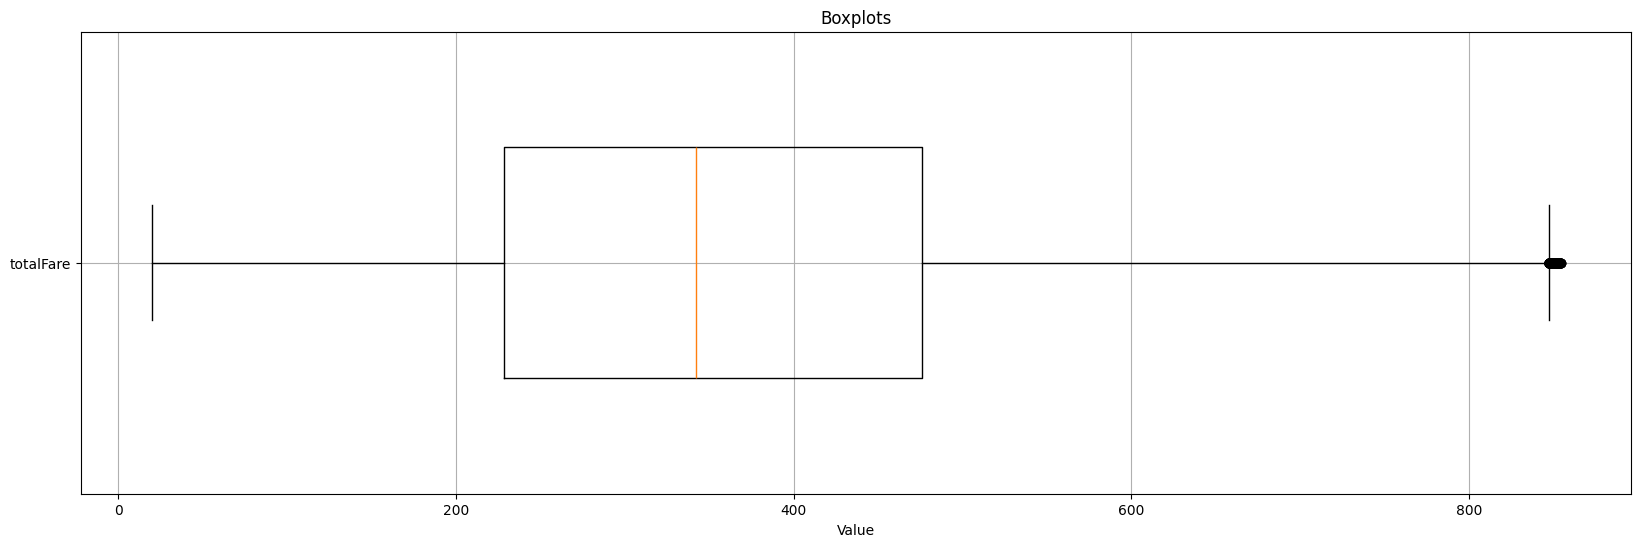

In [37]:
plot_boxplots(data=df, columns=["totalFare"])

In [38]:
df = remove_outliers_and_count(df, ["totalFare"])
df.show()
print(f"Количество строк после удаления выбросов: {df.count()}")

Столбец: totalFare | Число выбросов: 54491
Общее число выбросов во всех столбцах: 54491


+--------------------+----------+---------------+------------------+--------------+------------+---------+--------+------------------+--------------+-------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|baseFare|         totalFare|seatsRemaining|totalTravelDistance|
+--------------------+----------+---------------+------------------+--------------+------------+---------+--------+------------------+--------------+-------------------+
|915602a32f03ef585...|2022-05-23|            DTW|               LAX|         false|       false|    false|   480.0| 539.5999755859375|             7|             1985.0|
|925bc77c68beb3921...|2022-05-23|            DTW|               MIA|          true|       false|    false|  104.19| 141.1999969482422|             9|             1589.0|
|66bde28b940fda88d...|2022-05-23|            EWR|               DFW|         false|       false|     true|  245.58| 278.6000061035156|             3| 

Количество строк после удаления выбросов: 36652061


Минимальное значение:          19.59
Среднее значение:              362.55
Среднеквадратичное отклонение: 164.76
Первый квартиль:               228.60
Медиана:                       341.61
Третий квартиль:               474.61
Максимальное значение:         841.60


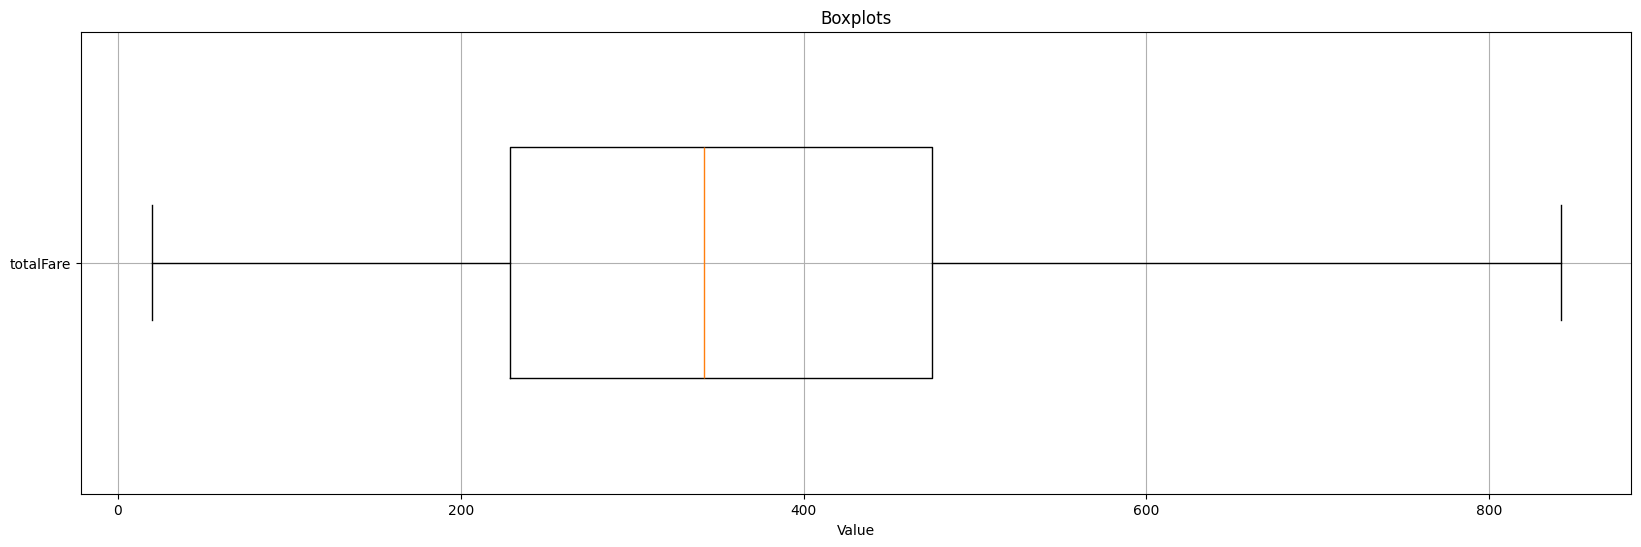

In [39]:
plot_boxplots(data=df, columns=["totalFare"])

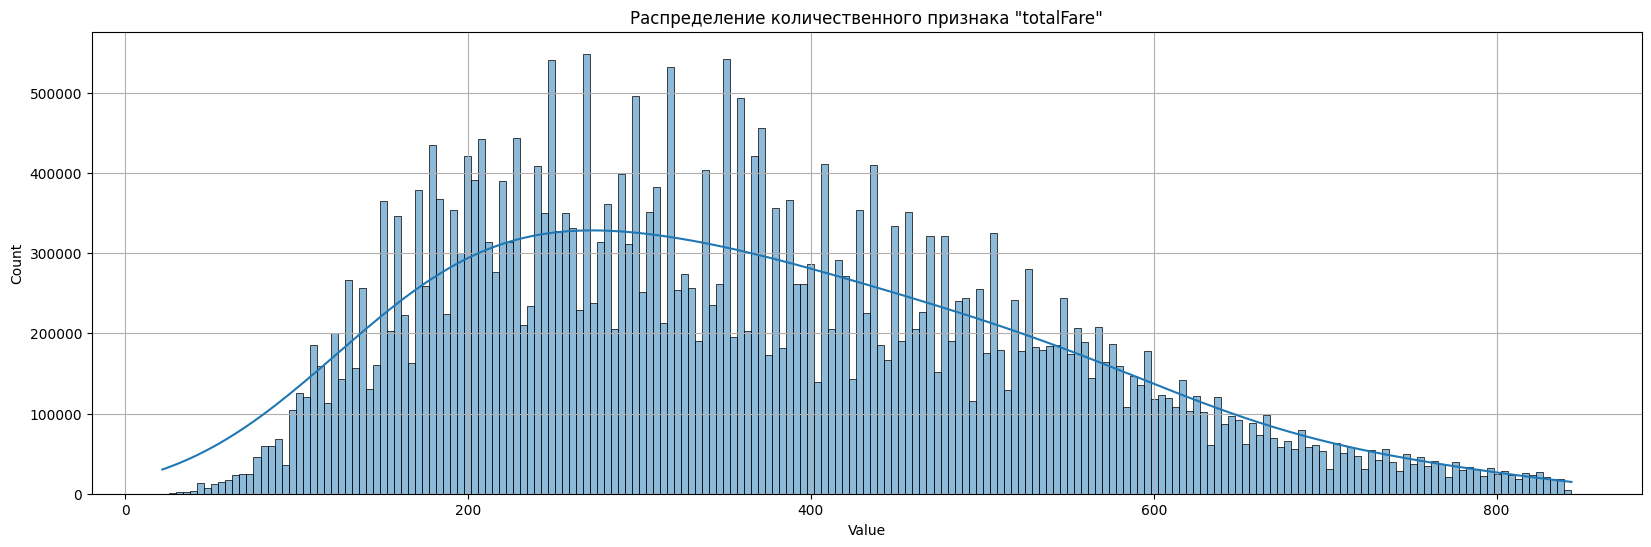

In [40]:
plot_quant_distribution(data=df, column="totalFare")

Теперь диаграмма более эффективно представляет данные в столбце.

In [41]:
df.show()

+--------------------+----------+---------------+------------------+--------------+------------+---------+--------+------------------+--------------+-------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|baseFare|         totalFare|seatsRemaining|totalTravelDistance|
+--------------------+----------+---------------+------------------+--------------+------------+---------+--------+------------------+--------------+-------------------+
|f2fa4c60f00d8562f...|2022-05-16|            PHL|               ORD|         false|       false|     true|  213.95|244.60000610351562|             2|              672.0|
|f60a4697d148f93c0...|2022-05-16|            SFO|               CLT|         false|       false|    false|  343.25|398.19000244140625|             7|             3426.0|
|0367a1e962bb512f0...|2022-05-16|            SFO|               DTW|         false|       false|    false|  524.65| 587.5999755859375|             9| 

#### Анализ столбца `baseFare`

In [42]:
count_nulls(data=df, column_name="baseFare")

Число колонок с NULL: 0 (0.00%)


Видно, что пропуски в данном столбце отсутствуют.



Минимальное значение:          0.01
Среднее значение:              313.63
Среднеквадратичное отклонение: 153.38
Первый квартиль:               189.77
Медиана:                       296.74
Третий квартиль:               418.60
Максимальное значение:         799.68


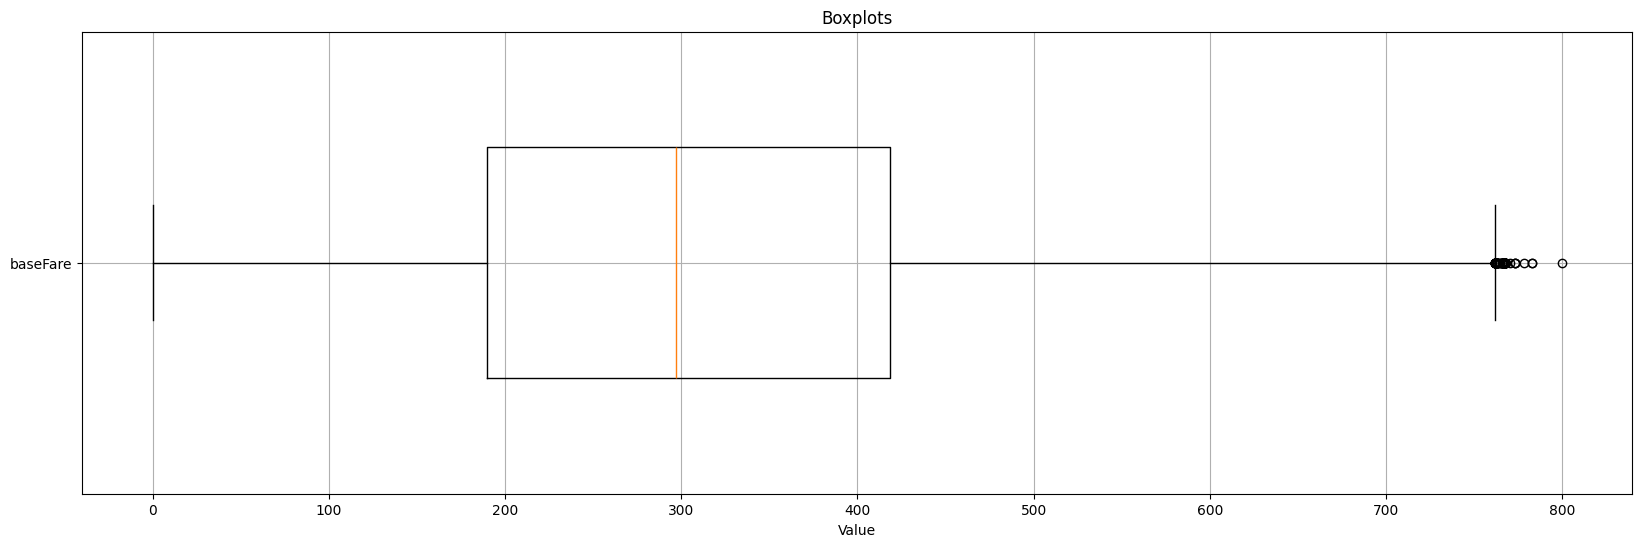

In [43]:
plot_boxplots(data=df, columns=["baseFare"])

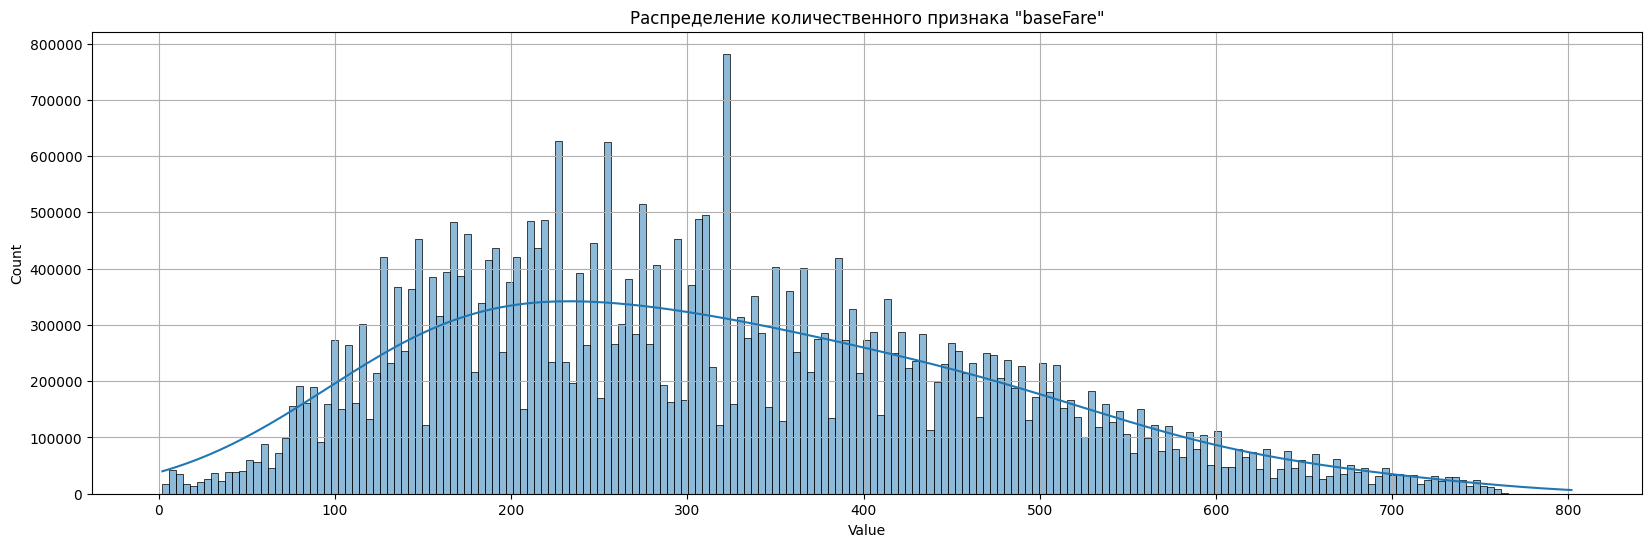

In [44]:
plot_quant_distribution(data=df, column="baseFare")

In [45]:
df = df.withColumn(
    "baseFare",
    when(col("baseFare") > 1500.0, 1500.0)
        .otherwise(col("baseFare"))
)

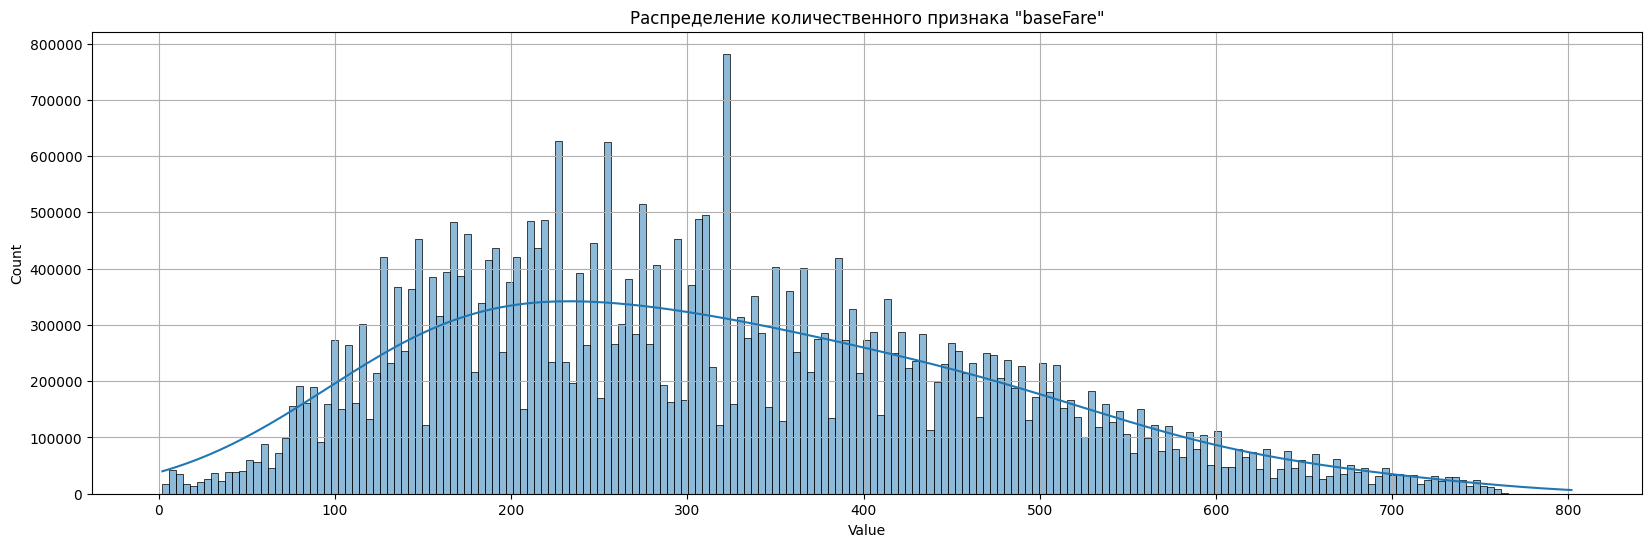

In [46]:
plot_quant_distribution(data=df, column="baseFare")

In [47]:
df = remove_outliers_and_count(df, ["baseFare"])
df.show()
print(f"Количество строк после удаления выбросов: {df.count()}")

Столбец: baseFare | Число выбросов: 9737
Общее число выбросов во всех столбцах: 9737


+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|          baseFare|         totalFare|seatsRemaining|totalTravelDistance|
+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+
|f2fa4c60f00d8562f...|2022-05-16|            PHL|               ORD|         false|       false|     true| 213.9499969482422|244.60000610351562|             2|              672.0|
|f60a4697d148f93c0...|2022-05-16|            SFO|               CLT|         false|       false|    false|            343.25|398.19000244140625|             7|             3426.0|
|0367a1e962bb512f0...|2022-05-16|            SFO|               DTW|         false|       false|    

Количество строк после удаления выбросов: 36642324


Минимальное значение:          0.01
Среднее значение:              313.51
Среднеквадратичное отклонение: 153.23
Первый квартиль:               189.77
Медиана:                       295.81
Третий квартиль:               418.60
Максимальное значение:         759.54


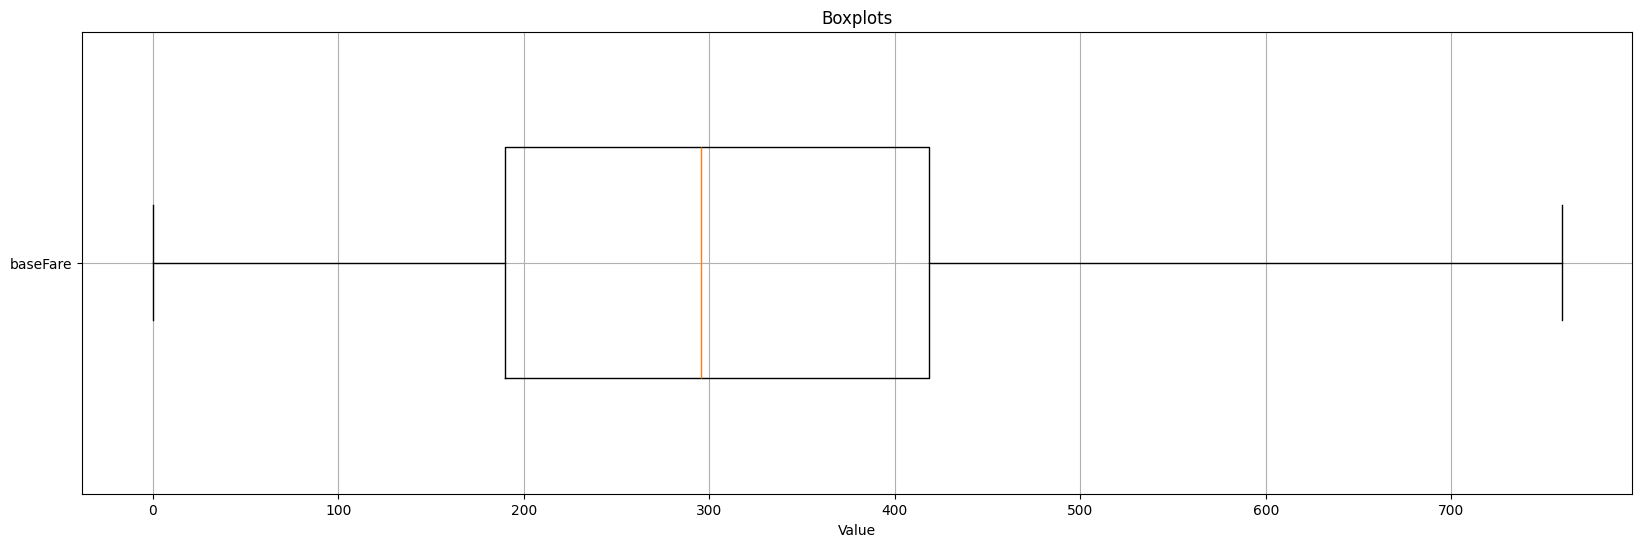

In [48]:
plot_boxplots(data=df, columns=["baseFare"])

In [49]:
df = remove_outliers_and_count(df, ["baseFare"])
df.show()
print(f"Количество строк после удаления выбросов: {df.count()}")

Столбец: baseFare | Число выбросов: 0
Общее число выбросов во всех столбцах: 0


+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|          baseFare|         totalFare|seatsRemaining|totalTravelDistance|
+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+
|915602a32f03ef585...|2022-05-23|            DTW|               LAX|         false|       false|    false|             480.0| 539.5999755859375|             7|             1985.0|
|925bc77c68beb3921...|2022-05-23|            DTW|               MIA|          true|       false|    false|104.19000244140625| 141.1999969482422|             9|             1589.0|
|66bde28b940fda88d...|2022-05-23|            EWR|               DFW|         false|       false|    

Количество строк после удаления выбросов: 36642324


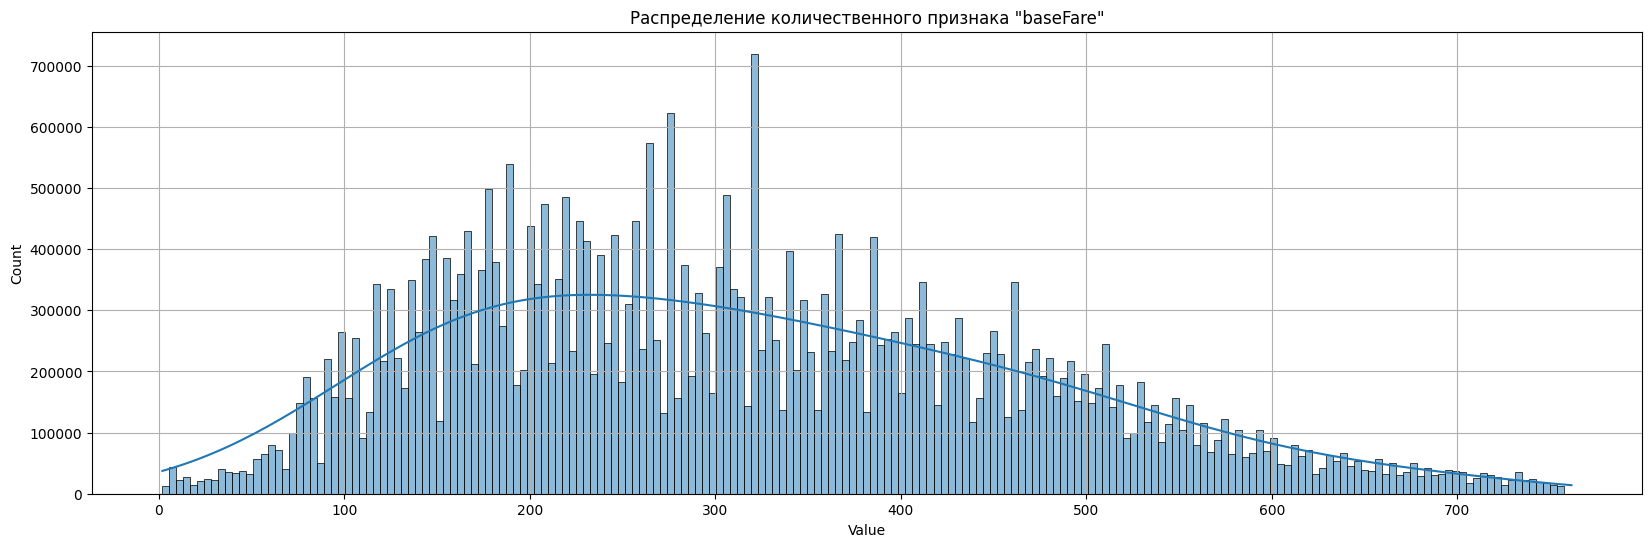

In [50]:
plot_quant_distribution(data=df, column="baseFare")

In [51]:
df.show()

+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|          baseFare|         totalFare|seatsRemaining|totalTravelDistance|
+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+
|f2fa4c60f00d8562f...|2022-05-16|            PHL|               ORD|         false|       false|     true| 213.9499969482422|244.60000610351562|             2|              672.0|
|f60a4697d148f93c0...|2022-05-16|            SFO|               CLT|         false|       false|    false|            343.25|398.19000244140625|             7|             3426.0|
|0367a1e962bb512f0...|2022-05-16|            SFO|               DTW|         false|       false|    

#### Анализ столбца `seatsRemaining` 
Данный столбец, согласно описанию и значениям, которые он принимает, можно отнести к **количественным**.

Выполним аналогичные шаги.

In [52]:
count_nulls(data=df, column_name="seatsRemaining")

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          0.00
Среднее значение:              5.30
Среднеквадратичное отклонение: 2.88
Первый квартиль:               3.00
Медиана:                       6.00
Третий квартиль:               7.00
Максимальное значение:         10.00


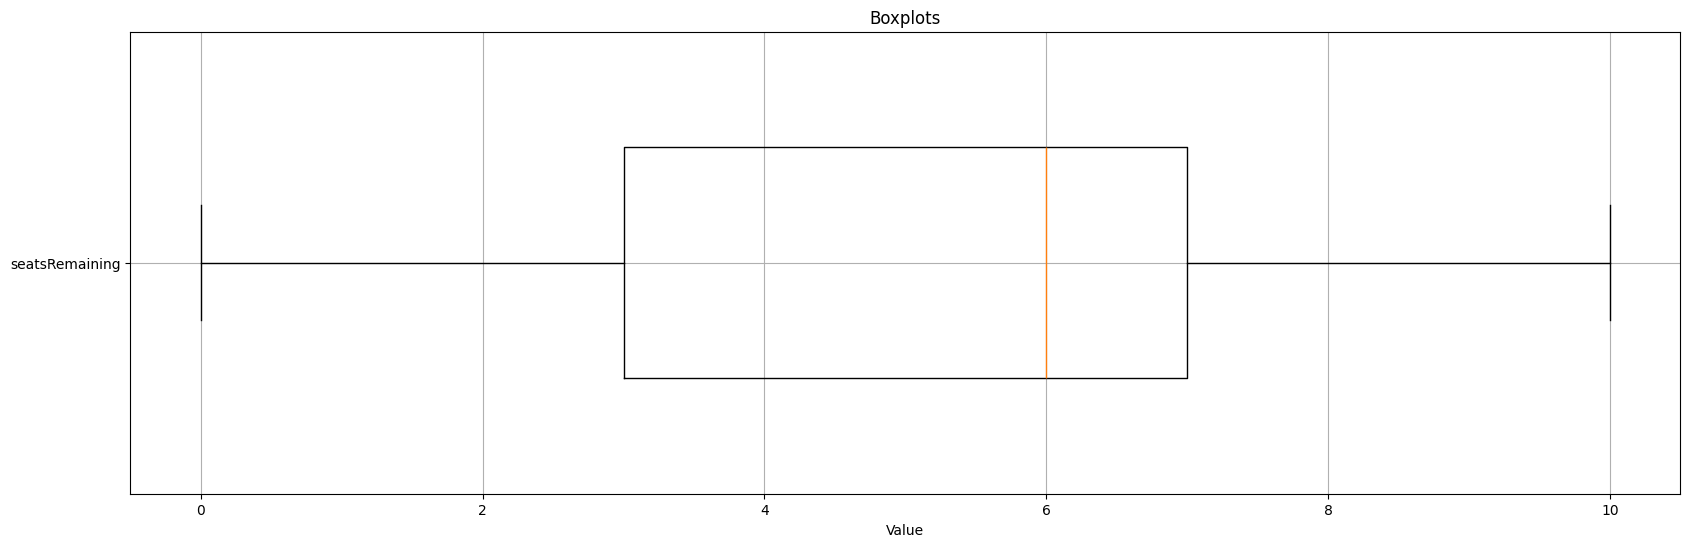

In [53]:
plot_boxplots(data=df, columns=["seatsRemaining"])

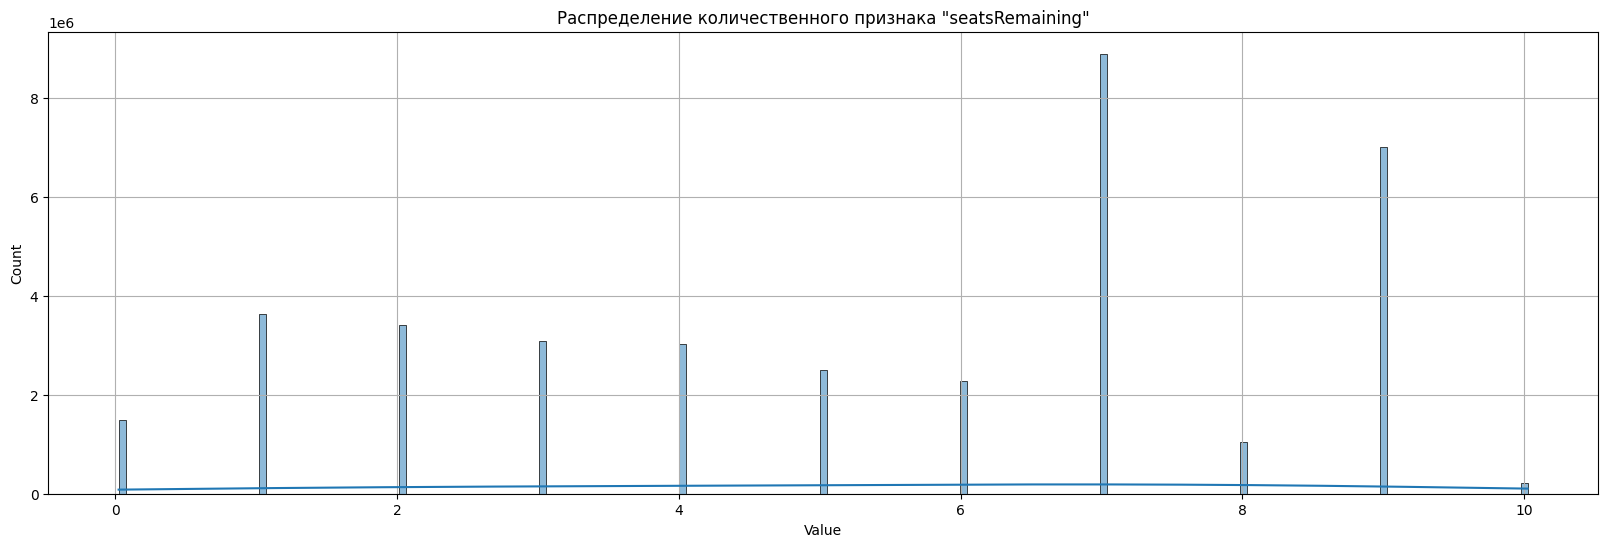

In [54]:
plot_quant_distribution(data=df, column="seatsRemaining")

#### Анализ столбца `totalTravelDistance`

Данный столбец, согласно описанию и значениям, которые он принимает, можно отнести к **количественным**.

Выполним аналогичные шаги.

In [55]:
count_nulls(data=df, column_name="totalTravelDistance")

Число колонок с NULL: 2223693 (6.07%)


Пропущено мало значений.

Минимальное значение:          89.00
Среднее значение:              1699.21
Среднеквадратичное отклонение: 844.46
Первый квартиль:               960.00
Медиана:                       1583.00
Третий квартиль:               2465.00
Максимальное значение:         4681.00


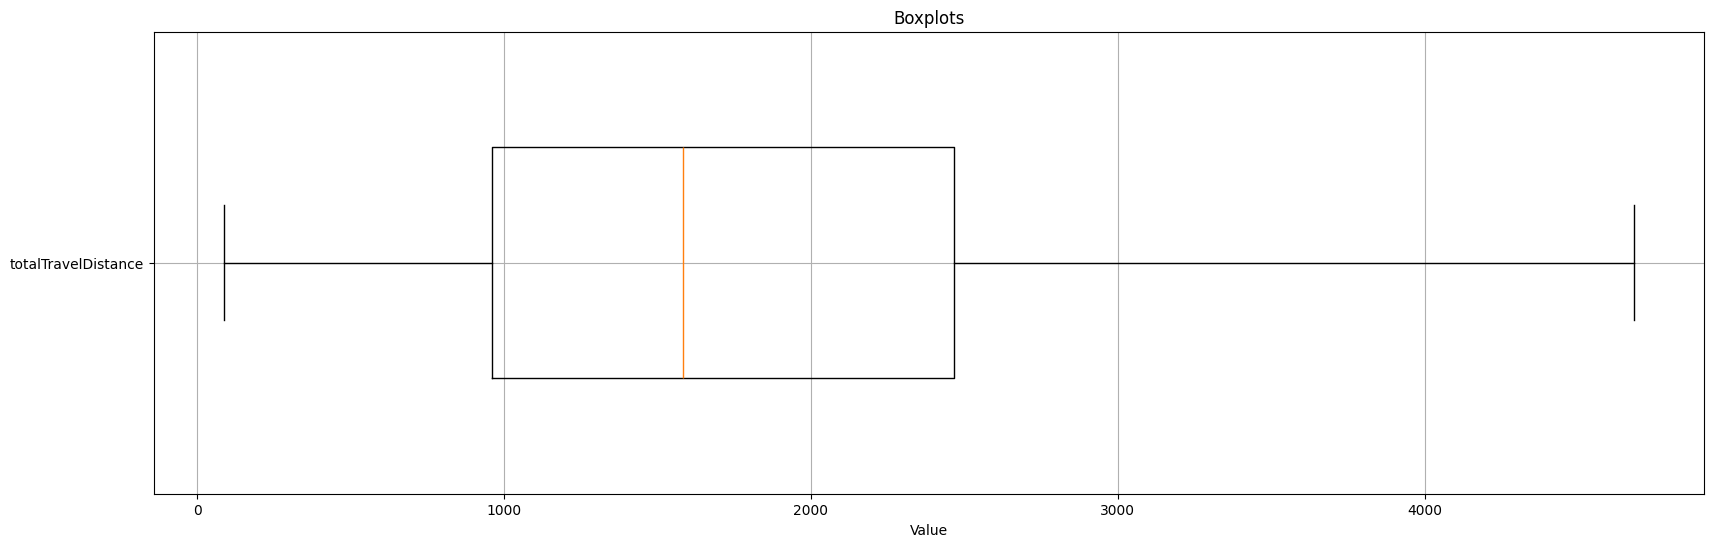

In [56]:
plot_boxplots(data=df, columns=["totalTravelDistance"])

In [57]:
df = remove_outliers_and_count(df, ["totalTravelDistance"])
df.show()
print(f"Количество строк после удаления выбросов: {df.count()}")

Столбец: totalTravelDistance | Число выбросов: 0
Общее число выбросов во всех столбцах: 0


+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|          baseFare|         totalFare|seatsRemaining|totalTravelDistance|
+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+
|915602a32f03ef585...|2022-05-23|            DTW|               LAX|         false|       false|    false|             480.0| 539.5999755859375|             7|             1985.0|
|925bc77c68beb3921...|2022-05-23|            DTW|               MIA|          true|       false|    false|104.19000244140625| 141.1999969482422|             9|             1589.0|
|66bde28b940fda88d...|2022-05-23|            EWR|               DFW|         false|       false|    

Количество строк после удаления выбросов: 34418631


In [58]:
from pyspark.sql.functions import mean

# Вычисляем среднее значение totalTravelDistance
mean_value = df.select(mean("totalTravelDistance")).collect()[0][0]

# Заполняем пропуски средним значением
df_filled_mean = df.fillna({"totalTravelDistance": mean_value})


In [59]:
count_nulls(data=df_filled_mean, column_name="totalTravelDistance")

Число колонок с NULL: 0 (0.00%)


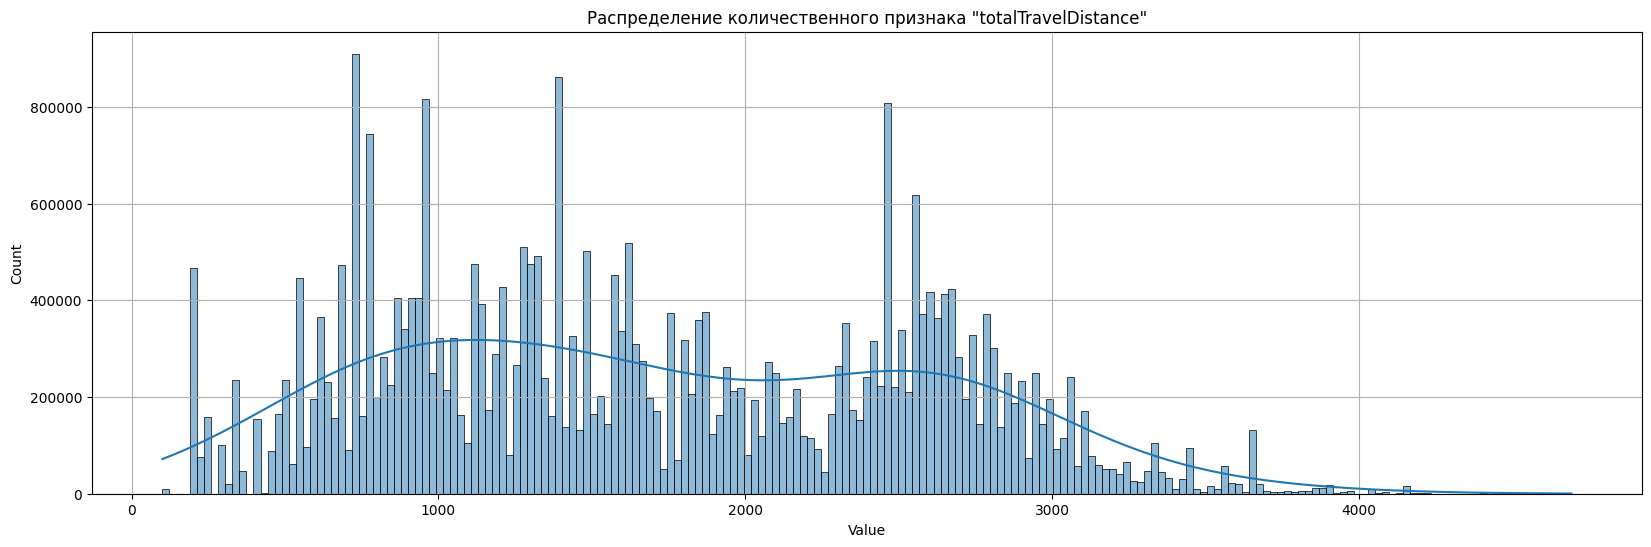

In [60]:
plot_quant_distribution(data=df_filled_mean, column="totalTravelDistance")

In [61]:
df = df.filter(col("totalTravelDistance").isNotNull())
count_nulls(data=df, column_name="totalTravelDistance")

Число колонок с NULL: 0 (0.00%)


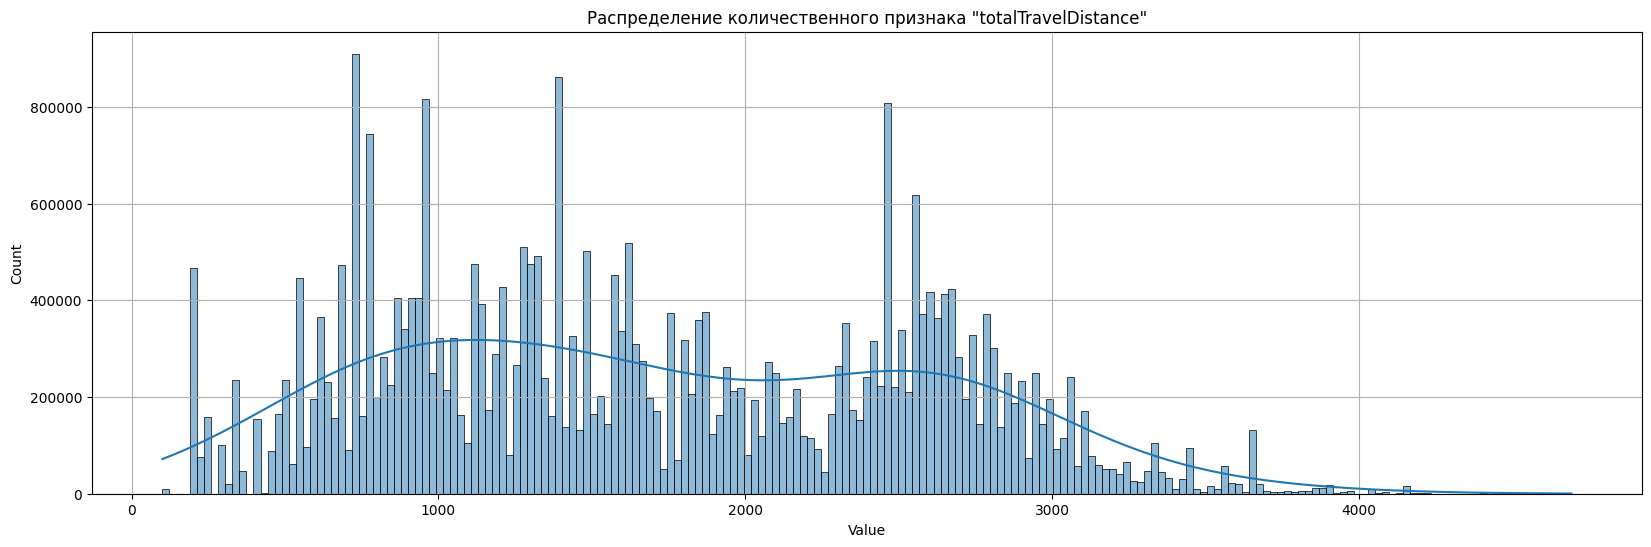

In [62]:
plot_quant_distribution(data=df, column="totalTravelDistance")

Минимальное значение:          89.00
Среднее значение:              1699.21
Среднеквадратичное отклонение: 844.46
Первый квартиль:               960.00
Медиана:                       1589.00
Третий квартиль:               2465.00
Максимальное значение:         4681.00


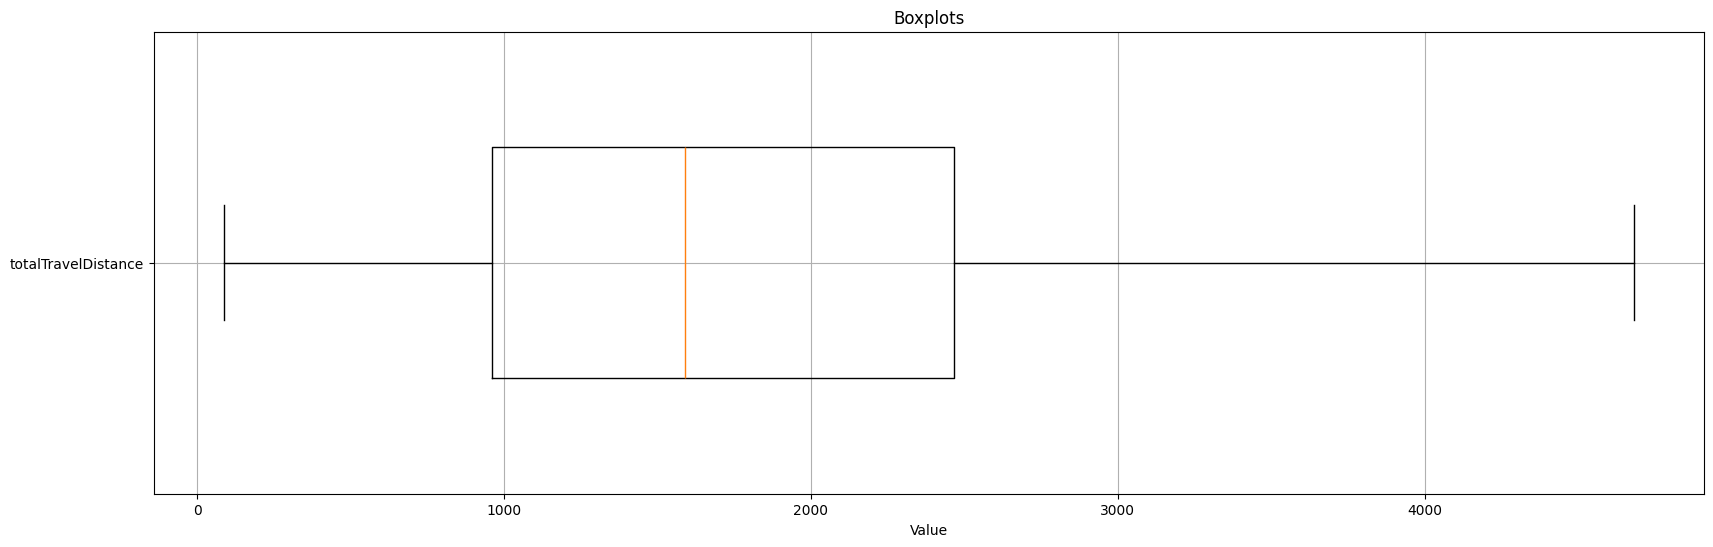

In [63]:
plot_boxplots(data=df, columns=["totalTravelDistance"])

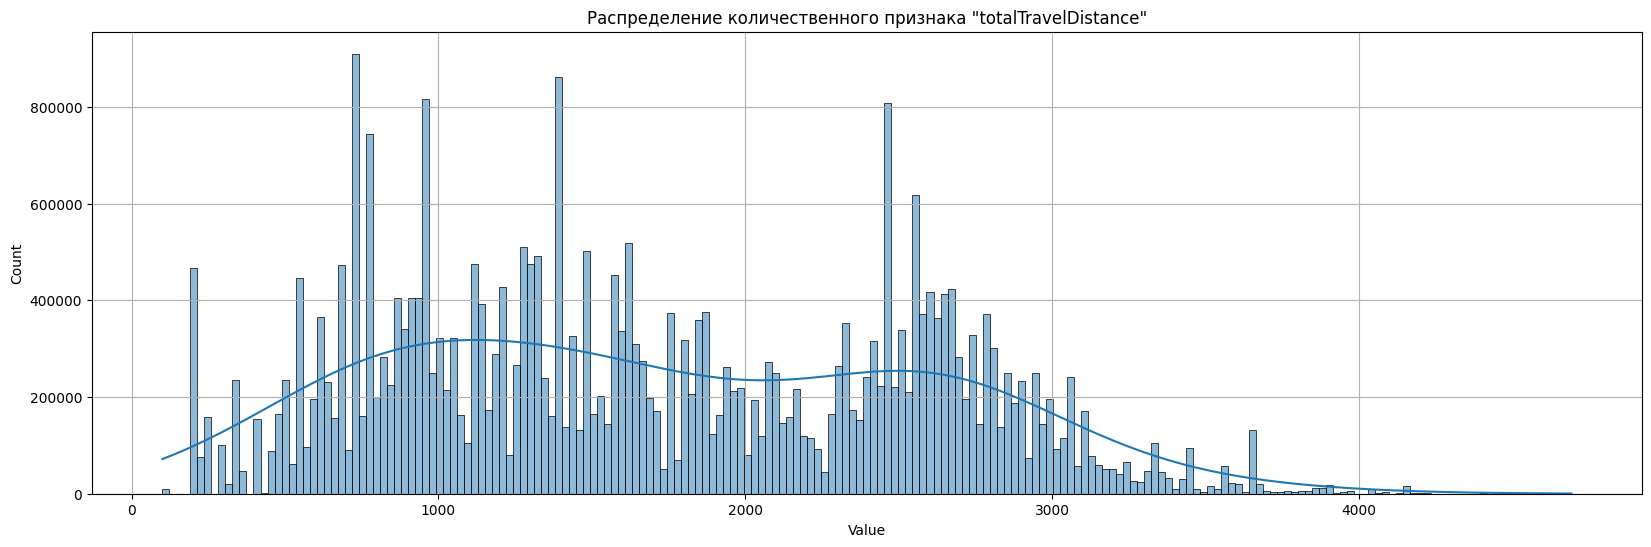

In [64]:
plot_quant_distribution(data=df, column="totalTravelDistance")

#### Анализ столбца `flightDate` 
Данный столбец, согласно описанию и значениям, которые он принимает, можно отнести к **количественным**.

Выполним аналогичные шаги.

In [65]:
count_nulls(data=df, column_name="flightDate")

Число колонок с NULL: 0 (0.00%)


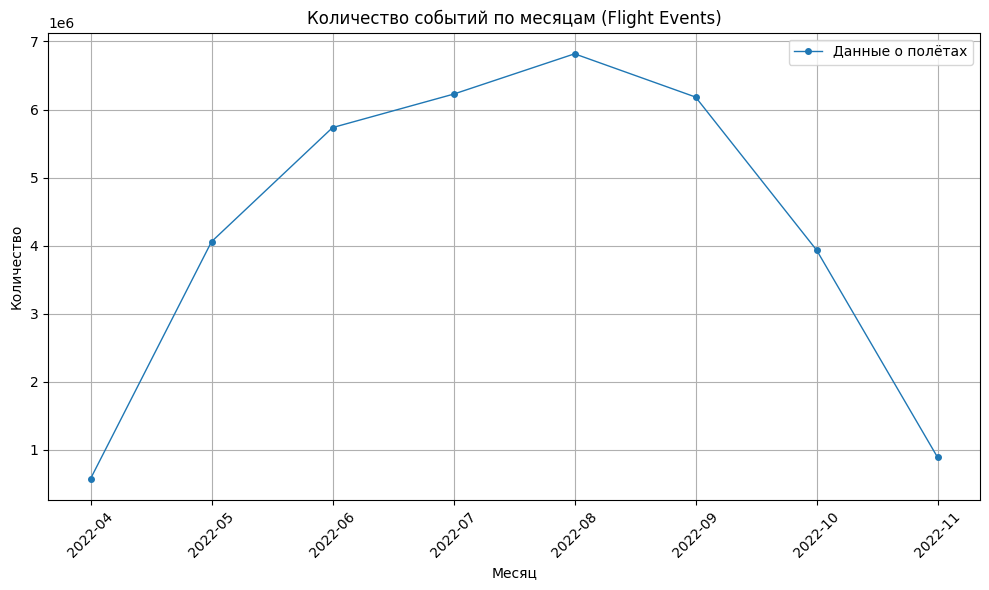

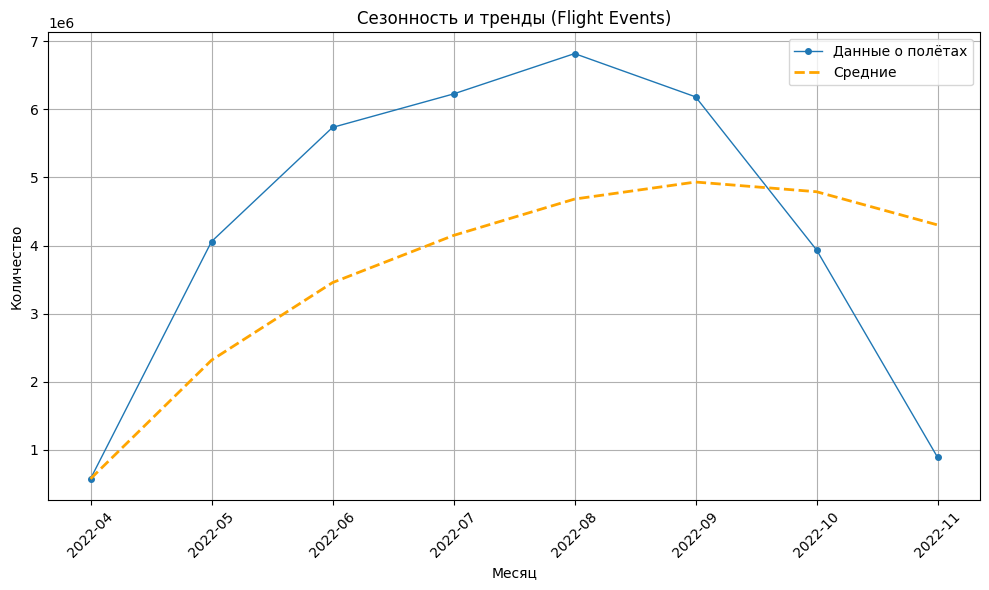

In [66]:
from pyspark.sql.functions import to_date, col, month, year, avg
from pyspark.sql.window import Window
import matplotlib.pyplot as plt


df = df.withColumn("flightDate", to_date(col("flightDate"), "yyyy-MM-dd"))

# Группировка по году и месяцу
flight_month_grouped = (
    df.groupBy(
        year("flightDate").alias("year"), 
        month("flightDate").alias("month")
    )
    .count()
    .orderBy("year", "month")
)

# Добавление
window_size = 12  
window_spec = (
    Window.partitionBy("year")  # Разделяем данные по году
    .orderBy("month")  # Упорядочиваем по месяцу
    .rowsBetween(-window_size + 1, 0)  # Окно скользящего среднего
)

flight_month_grouped = flight_month_grouped.withColumn(
    "rolling_mean",
    avg("count").over(window_spec)
)

# Преобразование данных для визуализации
plot_data = flight_month_grouped.collect()
years = [row["year"] for row in plot_data]
months = [row["month"] for row in plot_data]
counts = [row["count"] for row in plot_data]
rolling_means = [row["rolling_mean"] for row in plot_data]

# Подготовка данных для временной шкалы
timestamps = [f"{y}-{m:02d}" for y, m in zip(years, months)]

# Построение графика количества событий по месяцам
plt.figure(figsize=(10, 6))
plt.plot(timestamps, counts, label='Данные о полётах', marker='o', markersize=4, linewidth=1)
plt.title('Количество событий по месяцам (Flight Events)')
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.xticks(range(0, len(timestamps), max(len(timestamps)//10, 1)), rotation=45)  # Уменьшение числа меток
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Построение графика со сглаживанием
plt.figure(figsize=(10, 6))
plt.plot(timestamps, counts, label='Данные о полётах', marker='o', markersize=4, linewidth=1)
plt.plot(timestamps, rolling_means, label='Средние', color='orange', linestyle='--', linewidth=2)
plt.title('Сезонность и тренды (Flight Events)')
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.xticks(range(0, len(timestamps), max(len(timestamps)//10, 1)), rotation=45)  # Уменьшение числа меток
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Анализ столбцов `isBasicEconomy, isRefundable, isNonStop`

Данные признаки являются **бинарными** и имеют схожую интерпретацию. Проанализируем каждый признак. 

In [67]:
count_nulls(data=df, column_name="isBasicEconomy")

Число колонок с NULL: 0 (0.00%)


Количество категорий признака isBasicEconomy: 2


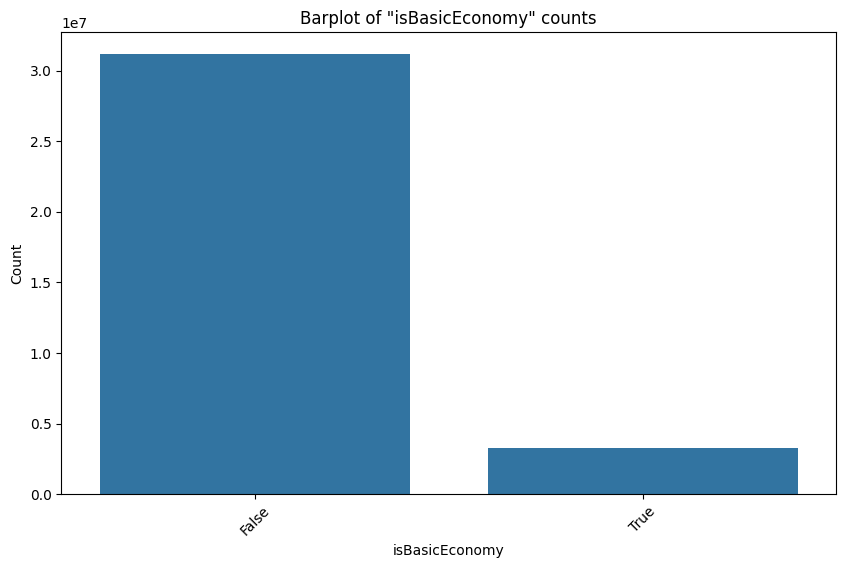

In [68]:
plot_cat_distribution(data=df, column_name="isBasicEconomy")

In [69]:
count_nulls(data=df, column_name="isRefundable")

Число колонок с NULL: 0 (0.00%)


Количество категорий признака isRefundable: 2


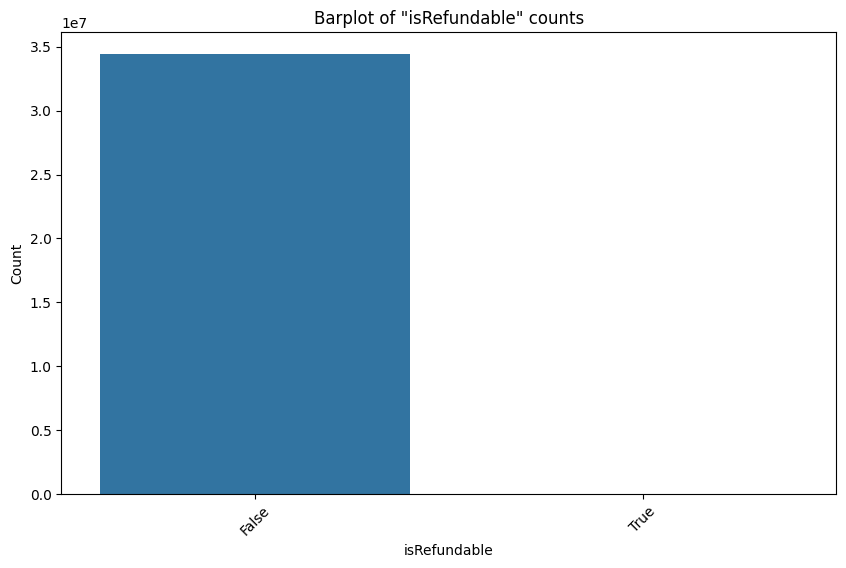

In [70]:
plot_cat_distribution(data=df, column_name="isRefundable")

In [71]:
df.groupBy("isRefundable").count().show()

+------------+--------+
|isRefundable|   count|
+------------+--------+
|        true|     379|
|       false|34418252|
+------------+--------+



In [72]:
count_nulls(data=df, column_name="isNonStop")

Число колонок с NULL: 0 (0.00%)


Количество категорий признака isNonStop: 2


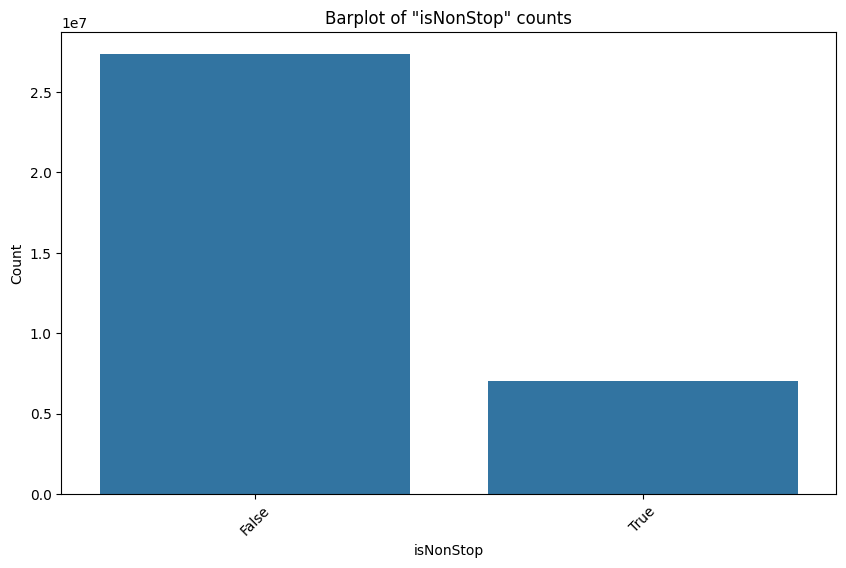

In [73]:
plot_cat_distribution(data=df, column_name="isNonStop")

In [74]:
df.show()

+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|          baseFare|         totalFare|seatsRemaining|totalTravelDistance|
+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+
|f2fa4c60f00d8562f...|2022-05-16|            PHL|               ORD|         false|       false|     true| 213.9499969482422|244.60000610351562|             2|              672.0|
|f60a4697d148f93c0...|2022-05-16|            SFO|               CLT|         false|       false|    false|            343.25|398.19000244140625|             7|             3426.0|
|0367a1e962bb512f0...|2022-05-16|            SFO|               DTW|         false|       false|    

Пропуски отсутствуют.

In [75]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Установим нужную дату
target_date = "2022-05-19" 

# Фильтрация до указанной даты 
filtered_df = df.filter(F.col("flightDate") <= target_date)

# Окна
# "flightDate" для подсчета общего числа вылетов по каждой дате
total_flight_window = Window.partitionBy("flightDate")

# "startingAirport" и "flightDate" для подсчета числа вылетов из каждого аэропорта на каждую дату
airport_flight_window = Window.partitionBy("startingAirport", "flightDate")

# Подсчет числа вылетов из каждого аэропорта на каждую дату
filtered_df = filtered_df.withColumn("airportFlights", F.count("legId").over(airport_flight_window))

# Подсчет общего числа вылетов на каждую дату
filtered_df = filtered_df.withColumn("totalFlights", F.count("legId").over(total_flight_window))

# Подсчет количества вылетов из других аэропортов на ту же дату
filtered_df = filtered_df.withColumn(
    "otherAirportsFlights",
    F.col("totalFlights") - F.col("airportFlights")
)

# Защита от деления на ноль для вычисления относительного числа вылетов
filtered_df = filtered_df.withColumn(
    "relativeFlightShareOtherAirports",
    F.when(F.col("otherAirportsFlights") != 0, F.col("airportFlights") / F.col("otherAirportsFlights"))
    .otherwise(F.lit(0))
)

# Результат
filtered_df.show()


+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|          baseFare|         totalFare|seatsRemaining|totalTravelDistance|airportFlights|totalFlights|otherAirportsFlights|relativeFlightShareOtherAirports|
+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|da4ff060d65dec9dc...|2022-05-19|            ATL|               IAD|         false|       false|    false|226.97999572753906| 266.1000061035156|             6|              555.0|          8870|      142433|       

Индвидуальное задание: Добавление нового признака к каждому аэропорту вылета. Добавить число - относительное кол-во вылетов относительно других аэропортов к дате.

In [76]:
from pyspark.sql.window import Window

#df = spark.table("sobd_lab1_table_1")

# Окна
# "flightDate" для подсчета общего числа вылетов по каждой дате
total_flight_window = Window.partitionBy("flightDate")

# "startingAirport" и "flightDate" для подсчета числа вылетов из каждого аэропорта на каждую дату
airport_flight_window = Window.partitionBy("startingAirport", "flightDate")

# Подсчет числа вылетов из каждого аэропорта на каждую дату
df = df.withColumn("airportFlights", count("legId").over(airport_flight_window))

# Подсчет общего числа вылетов на каждую дату
df = df.withColumn("totalFlights", count("legId").over(total_flight_window))

# Подсчет количества вылетов из других аэропортов на ту же дату
df = df.withColumn("otherAirportsFlights", col("totalFlights") - col("airportFlights"))

# Защита от деления на ноль для вычисления относительного числа вылетов
df = df.withColumn(
    "relativeFlightShareOtherAirports",
    when(col("otherAirportsFlights") != 0, col("airportFlights") / col("otherAirportsFlights"))
    .otherwise(lit(0))
)
df.show()


+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|          baseFare|         totalFare|seatsRemaining|totalTravelDistance|airportFlights|totalFlights|otherAirportsFlights|relativeFlightShareOtherAirports|
+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|3cea5f1ae0ff6ea2b...|2022-05-19|            ATL|               BOS|         false|       false|    false|319.07000732421875| 366.6000061035156|             8|              947.0|          8870|      142433|       

In [77]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Окна

# "flightDate" для подсчета общего числа вылетов по каждой дате до текущей
total_flight_window = Window.partitionBy("flightDate").orderBy("flightDate").rowsBetween(Window.unboundedPreceding, Window.currentRow)

# "startingAirport" и "flightDate" для подсчета числа вылетов из каждого аэропорта до текущей даты
airport_flight_window = Window.partitionBy("startingAirport", "flightDate").orderBy("flightDate").rowsBetween(Window.unboundedPreceding, Window.currentRow)

# Подсчет числа вылетов из каждого аэропорта до текущей даты
df = df.withColumn("airportFlights", F.count("legId").over(airport_flight_window))

# Подсчет общего числа вылетов до текущей даты
df = df.withColumn("totalFlights", F.count("legId").over(total_flight_window))

# Подсчет количества вылетов из других аэропортов до текущей даты
df = df.withColumn("otherAirportsFlights", F.col("totalFlights") - F.col("airportFlights"))

# Защита от деления на ноль для вычисления относительного числа вылетов
df = df.withColumn(
    "relativeFlightShareOtherAirports",
    F.when(F.col("otherAirportsFlights") != 0, F.col("airportFlights") / F.col("otherAirportsFlights"))
    .otherwise(F.lit(0))
)

df.show()


+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|          baseFare|         totalFare|seatsRemaining|totalTravelDistance|airportFlights|totalFlights|otherAirportsFlights|relativeFlightShareOtherAirports|
+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|fd98f6d85578a2bfb...|2022-05-19|            ATL|               BOS|         false|       false|    false|212.10000610351562| 257.2099914550781|             7|              947.0|             1|           1|       

In [78]:
df.printSchema()

root
 |-- legId: string (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: float (nullable = true)
 |-- airportFlights: long (nullable = false)
 |-- totalFlights: long (nullable = false)
 |-- otherAirportsFlights: long (nullable = false)
 |-- relativeFlightShareOtherAirports: double (nullable = true)



In [79]:
df.show()

+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|          baseFare|         totalFare|seatsRemaining|totalTravelDistance|airportFlights|totalFlights|otherAirportsFlights|relativeFlightShareOtherAirports|
+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|3cea5f1ae0ff6ea2b...|2022-05-19|            ATL|               BOS|         false|       false|    false|319.07000732421875| 366.6000061035156|             8|              947.0|             1|           1|       

In [80]:
count_nulls(data=df, column_name="airportFlights")

Число колонок с NULL: 0 (0.00%)


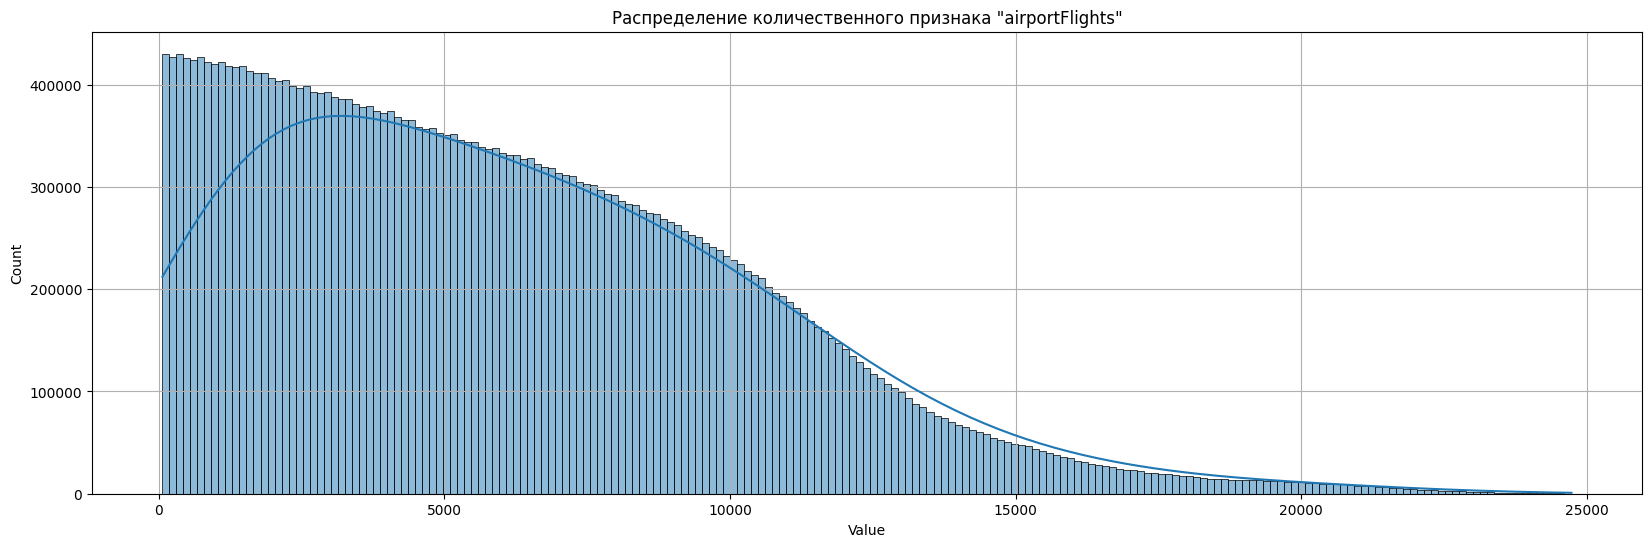

In [81]:
plot_quant_distribution(data=df, column="airportFlights")

In [82]:
count_nulls(data=df, column_name="relativeFlightShareOtherAirports")

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          0.00
Среднее значение:              0.07
Среднеквадратичное отклонение: 0.02
Первый квартиль:               0.06
Медиана:                       0.07
Третий квартиль:               0.08
Максимальное значение:         9.00


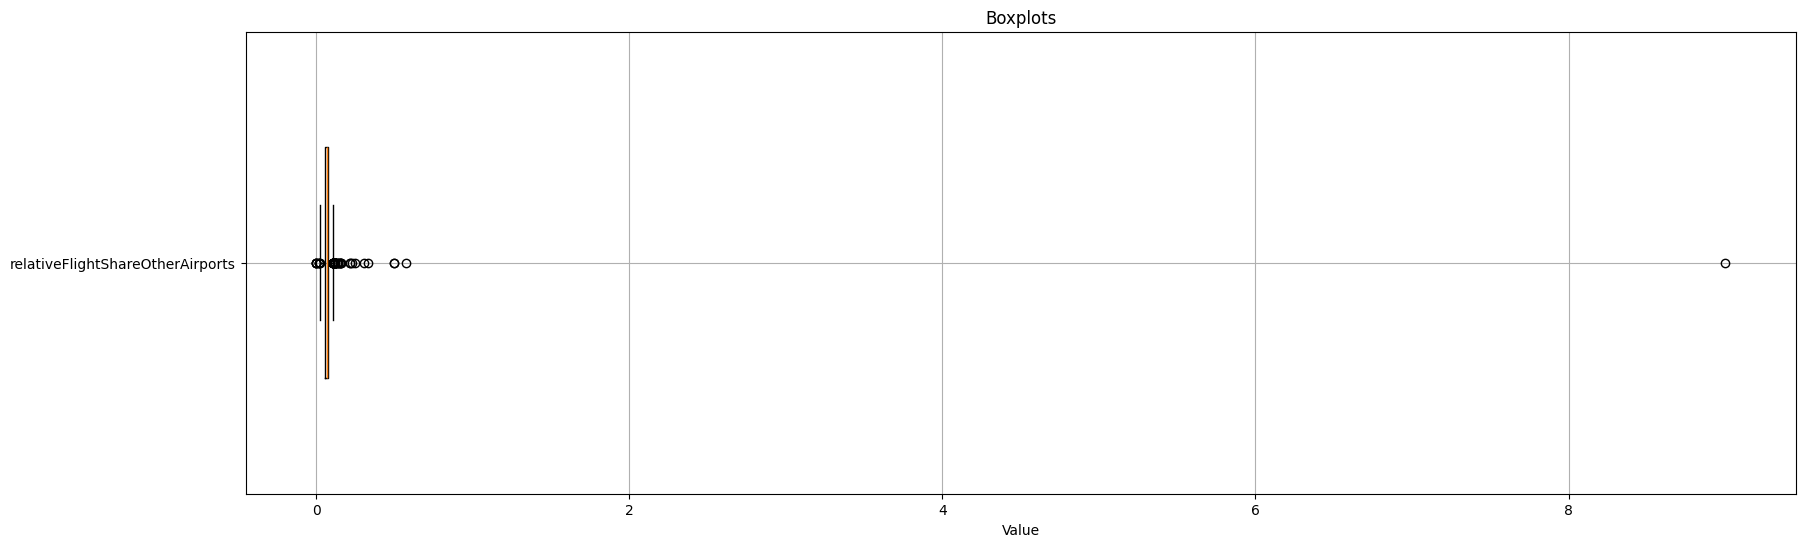

In [83]:
plot_boxplots(data=df, columns=["relativeFlightShareOtherAirports"])

In [84]:
df = remove_outliers_and_count(df, ["relativeFlightShareOtherAirports"])
df.show()
print(f"Количество строк после удаления выбросов: {df.count()}")

Столбец: relativeFlightShareOtherAirports | Число выбросов: 2644812
Общее число выбросов во всех столбцах: 2644812


+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|          baseFare|         totalFare|seatsRemaining|totalTravelDistance|airportFlights|totalFlights|otherAirportsFlights|relativeFlightShareOtherAirports|
+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|b923973a6b2b57a4a...|2022-05-19|            ATL|               EWR|         false|       false|    false|226.97999572753906| 266.1000061035156|             7|              773.0|             4|          41|       

Количество строк после удаления выбросов: 31731116


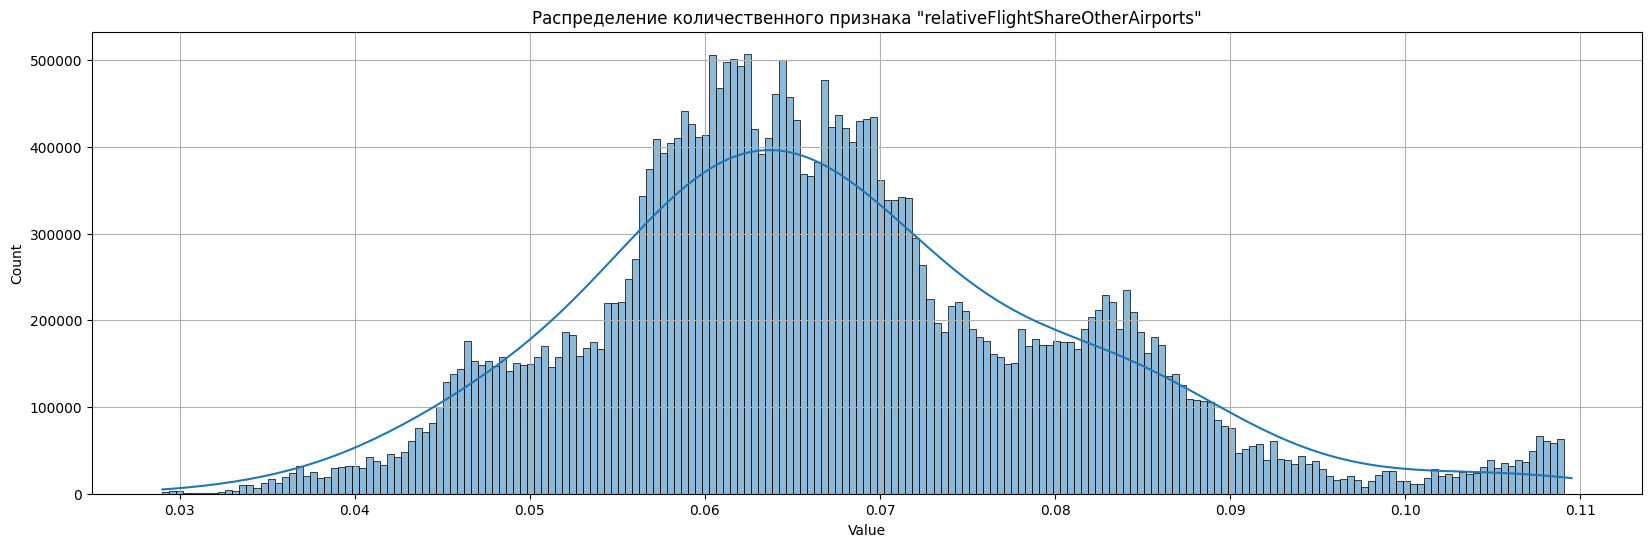

In [85]:
plot_quant_distribution(data=df, column="relativeFlightShareOtherAirports")

Минимальное значение:          0.03
Среднее значение:              0.07
Среднеквадратичное отклонение: 0.01
Первый квартиль:               0.06
Медиана:                       0.07
Третий квартиль:               0.07
Максимальное значение:         0.11


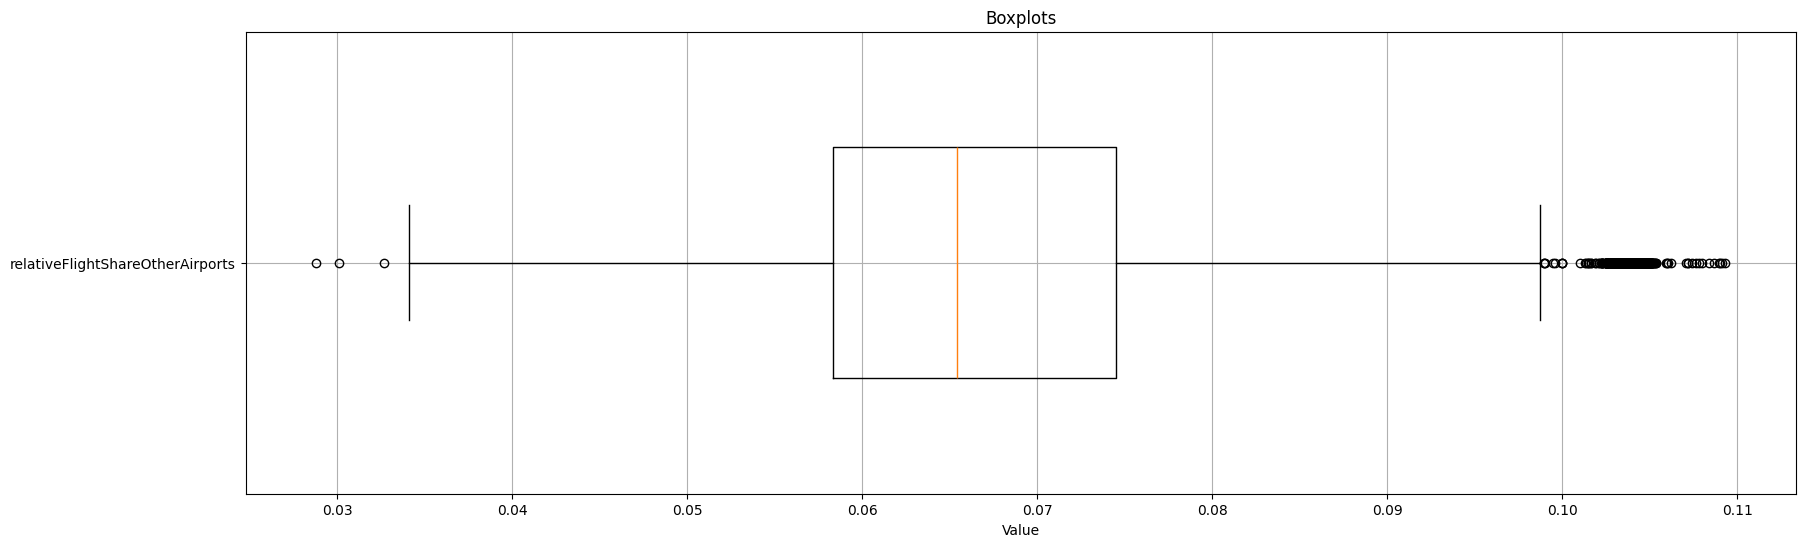

In [86]:
plot_boxplots(data=df, columns=["relativeFlightShareOtherAirports"])

In [87]:
df = remove_outliers_and_count(df, ["relativeFlightShareOtherAirports"])
df.show()
print(f"Количество строк после удаления выбросов: {df.count()}")

Столбец: relativeFlightShareOtherAirports | Число выбросов: 863946
Общее число выбросов во всех столбцах: 863946


+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|          baseFare|         totalFare|seatsRemaining|totalTravelDistance|airportFlights|totalFlights|otherAirportsFlights|relativeFlightShareOtherAirports|
+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|1907f547ec6ebf42d...|2022-05-19|            ATL|               EWR|         false|       false|     true| 185.1199951171875|213.60000610351562|             1|              762.0|             3|          45|       

Количество строк после удаления выбросов: 30871919


Минимальное значение:          0.03
Среднее значение:              0.07
Среднеквадратичное отклонение: 0.01
Первый квартиль:               0.06
Медиана:                       0.06
Третий квартиль:               0.07
Максимальное значение:         0.10


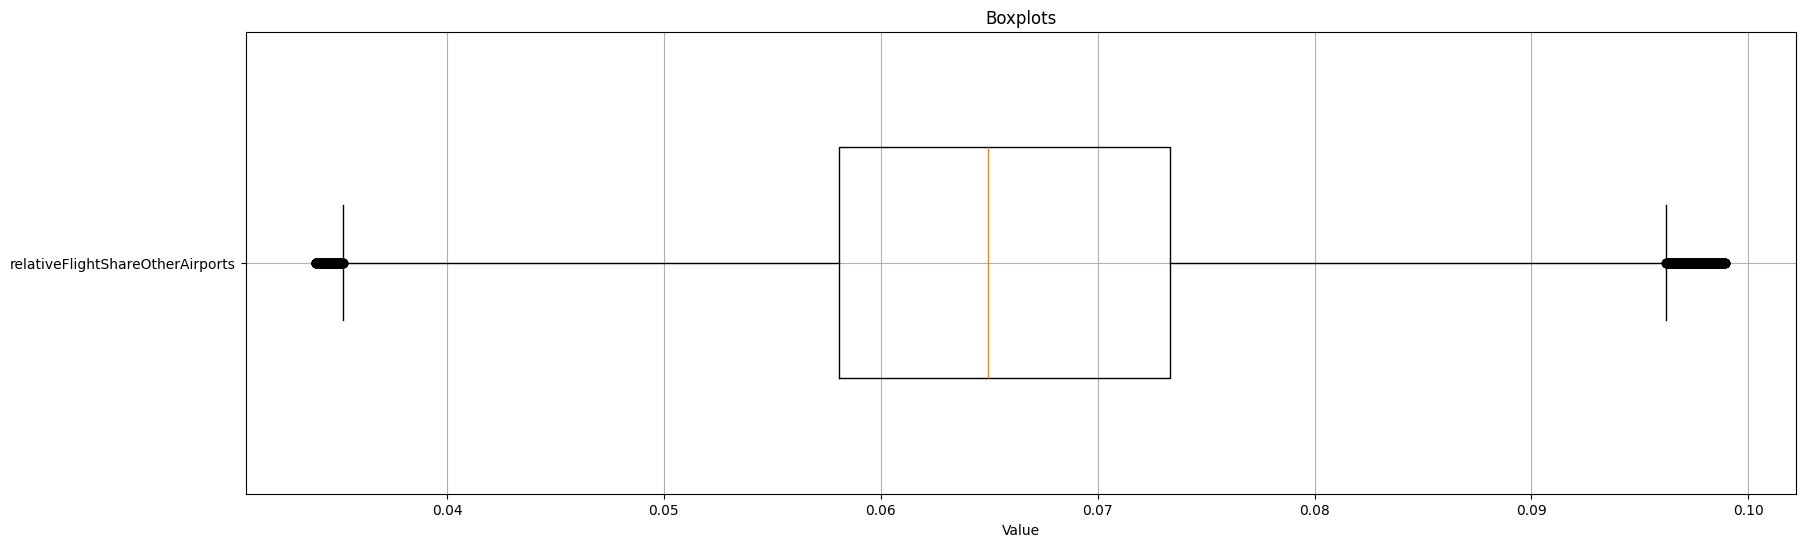

In [88]:
plot_boxplots(data=df, columns=["relativeFlightShareOtherAirports"])

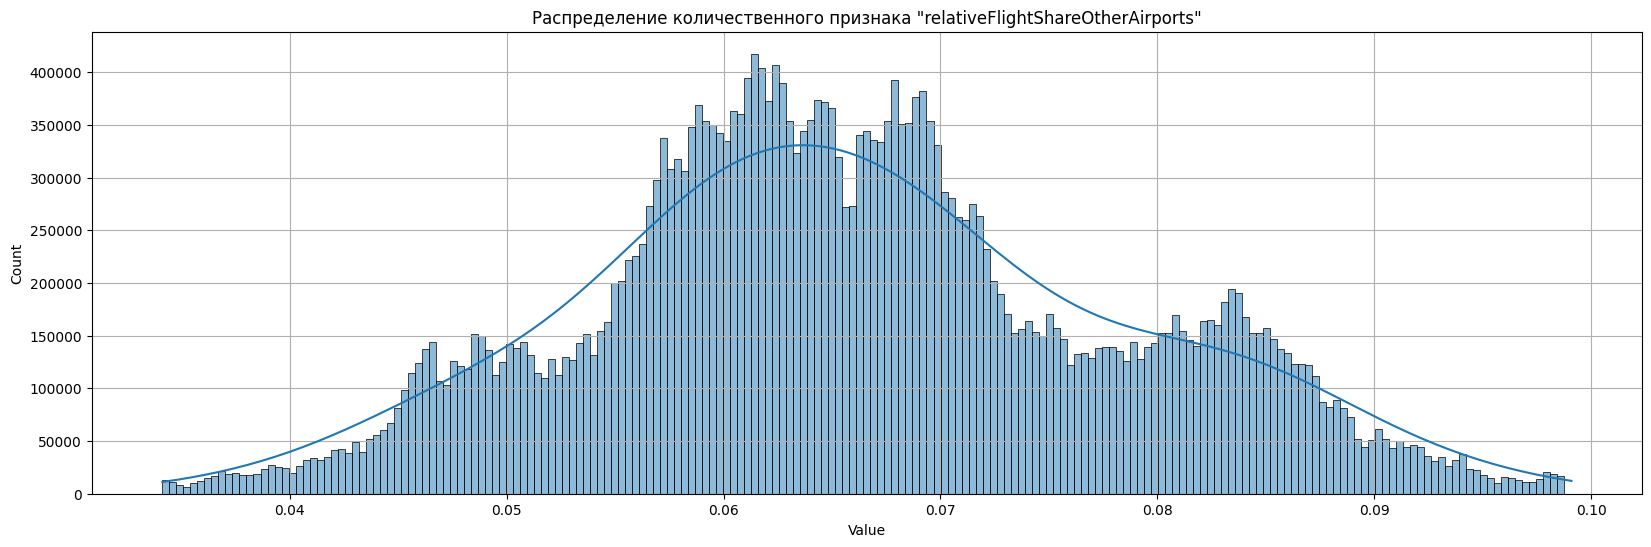

In [ ]:
plot_quant_distribution(data=df, column="relativeFlightShareOtherAirports")

In [ ]:
# Фильтруем данные, чтобы показать только строки с различными аэропортами
df_filtered = df.filter(col("startingAirport") != col("destinationAirport"))

# Показываем результат
df_filtered.show()

+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|          baseFare|         totalFare|seatsRemaining|totalTravelDistance|airportFlights|totalFlights|otherAirportsFlights|relativeFlightShareOtherAirports|
+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|1907f547ec6ebf42d...|2022-05-19|            ATL|               EWR|         false|       false|     true| 185.1199951171875|213.60000610351562|             1|              762.0|             3|          45|       

In [ ]:
df.show() 

+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|          baseFare|         totalFare|seatsRemaining|totalTravelDistance|airportFlights|totalFlights|otherAirportsFlights|relativeFlightShareOtherAirports|
+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|53903b1f018d98c6d...|2022-05-19|            ATL|               JFK|         false|       false|    false| 202.7899932861328|240.10000610351562|             5|              773.0|             6|          75|       

#### Расчет корреляции между количественными признаками

In [92]:
def compute_and_visualize_correlation_matrix(data: DataFrame, 
                                             columns: list[str]) -> None:
    """
    Вычисляет и визуализирует корреляционную матрицу для указанных 
    колонок в DataFrame PySpark.

    Args:
        df (DataFrame): DataFrame PySpark.
        columns (list[str]): Список колонок для вычисления корреляции.

    Returns:
        None
    """
    # Вычисление корреляционной матрицы
    corr_matrix = {}
    for col1 in columns:
        corr_matrix[col1] = {}
        for col2 in columns:
            corr_value = data.select(corr(col1, col2)).collect()[0][0]
            corr_matrix[col1][col2] = corr_value

    # Преобразование корреляционной матрицы в DataFrame Pandas для визуализации
    corr_matrix_pd = pd.DataFrame(corr_matrix)

    # Построение и визуализация корреляционной матрицы
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix_pd, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

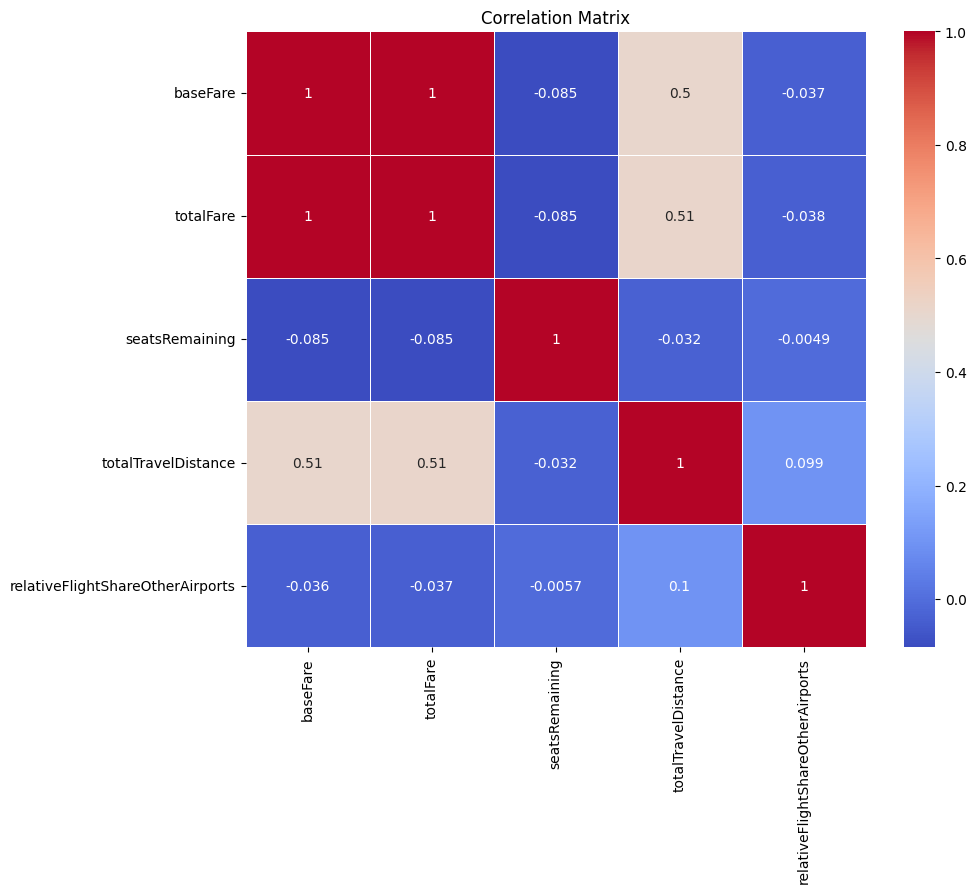

In [ ]:
compute_and_visualize_correlation_matrix(
    data=df, columns=[
        "baseFare", "totalFare", "seatsRemaining",
        "totalTravelDistance","relativeFlightShareOtherAirports"]
)

Корреляционная матрица демонстрирует наличие корреляции между некоторыми количественными признаками.

In [ ]:
df.show()

+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|          baseFare|         totalFare|seatsRemaining|totalTravelDistance|airportFlights|totalFlights|otherAirportsFlights|relativeFlightShareOtherAirports|
+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|adfc238f13623db4d...|2022-05-19|            ATL|               BOS|         false|       false|    false| 258.6000061035156| 300.1000061035156|             7|              956.0|             3|          43|       

Посмотрим, сколько объектов осталось после преобразований датасета.

In [ ]:
df.count()

30883341

In [96]:
df.printSchema()

root
 |-- legId: string (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: float (nullable = true)
 |-- airportFlights: long (nullable = false)
 |-- totalFlights: long (nullable = false)
 |-- otherAirportsFlights: long (nullable = false)
 |-- relativeFlightShareOtherAirports: double (nullable = true)



Сохраняет очищенную и обработанную таблицу на диск.

In [ ]:
# Сохранение DataFrame в виде таблицы
df.writeTo("sobd_lab1_processed_table_1").using("iceberg").create()

In [98]:
for table in spark.catalog.listTables():
    print(table.name)

sobd_lab1_processed_table_1
sobd_lab1_table_1


Обратите внимание, что при необходимости созданные базу данных и таблицу можно удалить следующими командами.

In [99]:
#spark.sql("DROP TABLE spark_catalog.kachurin_database.sobd_lab1_table_1")
#spark.sql("DROP DATABASE spark_catalog.kachurin_database")

Останавливаем `Spark`-сессию.

In [ ]:
spark.stop()